# Pablo's Playhouse for Data Analysis

In [ ]:
# import libraries
import pandas as pd
import geopandas as gpd

# Define data path
dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'
dataPath_esp = '../data/merged_data/merged_birthPlace_spain_v_outside.csv'

# Load merged datasets
df_region = pd.read_csv(dataPath_region)
df_esp = pd.read_csv(dataPath_esp)









<Axes: >

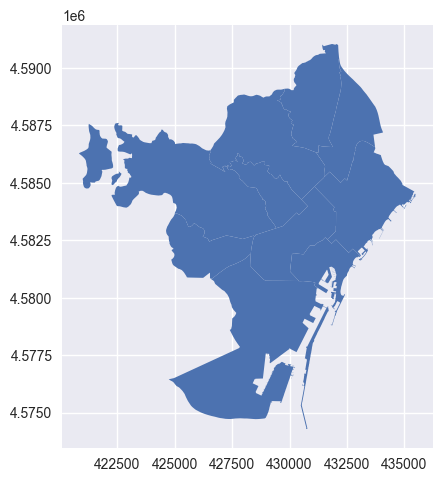

In [45]:
import geopandas as gpd

# Reading a GeoPackage file
input_file = "../data_original/esforc_lloguer/16-17_hab_dif_od.gpkg"
data = gpd.read_file(input_file)

# Show map preview
data.plot()



## Map of Barcelona Neighborhoods by District

(430018.6185, 4580195.801, 431677.344, 4581936.9845)


<Axes: >

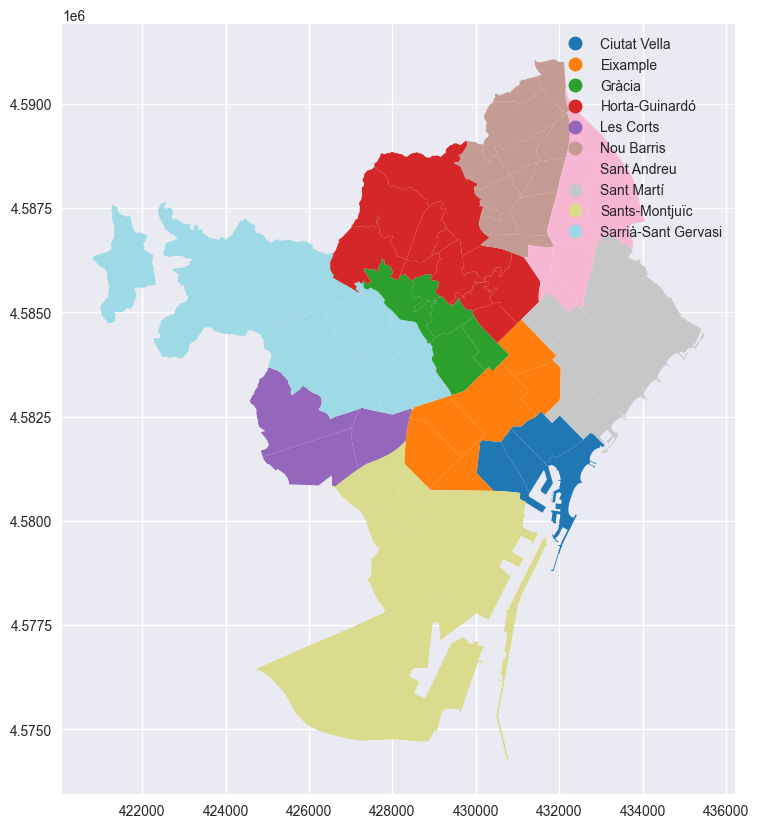

In [46]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# read csv
path_barris = '../data_original/Codigo_valores/BarcelonaCiutat_Barris.csv'
df = pd.read_csv(path_barris)

# convert WKT strings to geometry objects
df["geometria_etrs89"] = df["geometria_etrs89"].apply(wkt.loads)   # or gpd.GeoSeries.from_wkt(df["geometry"])

# create GeoDataFrame and set the correct ETRS89 CRS
# Choose the right EPSG: EPSG:4258 for geographic ETRS89 (lat/lon),
# EPSG:25831 for ETRS89 / UTM zone 31N (meters) — choose one that matches your coordinates
gdf = gpd.GeoDataFrame(df, geometry="geometria_etrs89", crs="EPSG:25831")

# quick check of bounds to confirm units
print(gdf.geometry.iloc[0].bounds)

# Plot map with neighborhoods by district by color
gdf.plot(column="nom_districte", legend=True, figsize=(10, 10), cmap="tab20")






## Map of immigration in Barcelona by neighborhood

In [47]:
# import libraries
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
# read csv
path_barris = '../data_original/Codigo_valores/BarcelonaCiutat_Barris.csv'
df = pd.read_csv(path_barris)

# read csv from immigrant data
path_immigrant = '../data/merged_data/merged_birthPlace_spain_v_outside.csv'
df_immigrant = pd.read_csv(path_immigrant)
df_immigrant['Value'] = pd.to_numeric(df_immigrant['Value'], errors='coerce').fillna(0).astype(int)
df_immigrant['Birth_Place'] = df_immigrant['Birth_Place'].astype(str).str.strip()
# get data from 2025 only
df_immigrant_2025 = df_immigrant[df_immigrant['Year_Reference'] == 2025]

# total population by neighborhood
total = df_immigrant_2025.groupby(['District', 'Neighborhood'], as_index=False)['Value'].sum().rename(columns={'Value':'total_population'})

# population from Rest of European Union and Rest of World
eu = df_immigrant_2025[df_immigrant_2025['Birth_Place'] == 'Rest of European Union'].groupby(['District','Neighborhood'], as_index=False)['Value'].sum().rename(columns={'Value':'eu_population'})
world = df_immigrant_2025[df_immigrant_2025['Birth_Place'] == 'Rest of World'].groupby(['District','Neighborhood'], as_index=False)['Value'].sum().rename(columns={'Value':'world_population'})

# combine
summary = total.merge(eu, on=['District','Neighborhood'], how='left').merge(world, on=['District','Neighborhood'], how='left').fillna(0)
summary['outside_spain'] = summary['eu_population'] + summary['world_population']
# Calculate population from Spain
summary['spain_population'] = summary['total_population'] - summary['outside_spain']
# reorder columns
summary = summary[['District', 'Neighborhood', 'total_population', 'spain_population', 'outside_spain', 'eu_population', 'world_population']]
# Percentage of population from outside Spain
summary['pct_outside_spain'] = (summary['outside_spain'] / summary['total_population'] * 100).round(2)


# save and inspect
summary.to_csv('../data/processed/neighborhood_population_summary_2025.csv', index=False)
print(summary.head())



       District                           Neighborhood  total_population  \
0  Ciutat Vella  Sant Pere, Santa Caterina i la Ribera             22755   
1  Ciutat Vella                         el Barri Gòtic             27863   
2  Ciutat Vella                               el Raval             49889   
3  Ciutat Vella                         la Barceloneta             14741   
4      Eixample                            Sant Antoni             39207   

   spain_population  outside_spain  eu_population  world_population  \
0              9273          13482           3384             10098   
1              6765          21098           2556             18542   
2             17183          32706           3848             28858   
3              6803           7938           2056              5882   
4             24197          15010           2585             12425   

   pct_outside_spain  
0              59.25  
1              75.72  
2              65.56  
3              53.85  
4

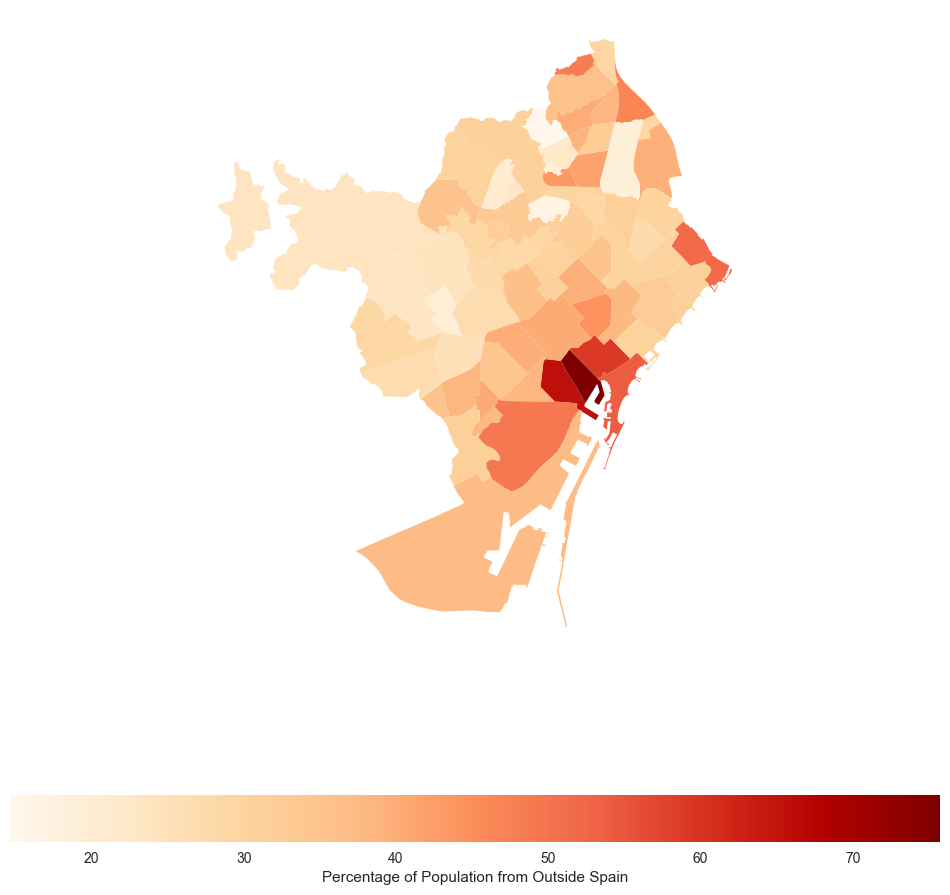

In [48]:
# Now we merge with geospatial data and plot
# convert WKT strings to geometry objects
df["geometria_etrs89"] = df["geometria_etrs89"].apply(wkt.loads)   # or gpd.GeoSeries.from_wkt(df["geometry"])
# create GeoDataFrame and set the correct ETRS89 CRS
# Choose the right EPSG: EPSG:4258 for geographic ETRS89 (lat/lon),
# EPSG:25831 for ETRS89 / UTM zone  31N (meters) — choose one that matches your coordinates
gdf = gpd.GeoDataFrame(df, geometry="geometria_etrs89", crs="EPSG:25831")
# merge with summary data
gdf_summary = gdf.merge(summary, left_on=['nom_districte', 'nom_barri'], right_on=['District', 'Neighborhood'], how='left')
# plot percentage of population from outside Spain
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_summary.plot(column='pct_outside_spain', ax=ax, legend=True, cmap='OrRd', 
                 legend_kwds={'label': "Percentage of Population from Outside Spain", 'orientation': "horizontal"})
#ax.set_title('Percentage of Population from Outside Spain by Neighborhood in Barcelona (2025)', fontsize=16)
ax.axis('off')
plt.show()

## Temporal series: GIF 

In [49]:
# Retrieve total population and immigration from outside Spain by neighborhood in Barcelona for every year
import pandas as pd
# read csv
path = '../data/merged_data/merged_birthPlace_spain_v_outside.csv'
df = pd.read_csv(path)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)
df['Birth_Place'] = df['Birth_Place'].astype(str).str.strip()
years = df['Year_Reference'].unique()

# total population by neighborhood
total = df.groupby(['Year_Reference', 'District', 'Neighborhood'], as_index=False)['Value'].sum().rename(columns={'Value':'total_population'})

# population from Rest of European Union and Rest of World
eu = df[df['Birth_Place'] == 'Rest of European Union'].groupby(['Year_Reference', 'District','Neighborhood'], as_index=False)['Value'].sum().rename(columns={'Value':'eu_population'})
world = df[df['Birth_Place'] == 'Rest of World'].groupby(['Year_Reference', 'District','Neighborhood'], as_index=False)['Value'].sum().rename(columns={'Value':'world_population'})

# combine
summary = total.merge(eu, on=['Year_Reference', 'District','Neighborhood'], how='left').merge(world, on=['Year_Reference', 'District','Neighborhood'], how='left').fillna(0)
summary['outside_spain'] = summary['eu_population'] + summary['world_population']
# Calculate population from Spain
summary['spain_population'] = summary['total_population'] - summary['outside_spain']
# reorder columns with Year_Reference first and sort by year
summary = summary[['Year_Reference', 'District', 'Neighborhood', 'total_population', 'spain_population', 'outside_spain', 'eu_population', 'world_population']]
summary = summary.sort_values('Year_Reference')
# Percentage of population from outside Spain
summary['pct_outside_spain'] = (summary['outside_spain'] / summary['total_population'] * 100).round(2)


# save and inspect
summary.to_csv('../data/processed/neighborhood_population_summary.csv', index=False)
print(summary.head())



    Year_Reference      District  \
0             1997  Ciutat Vella   
52            1997    Sant Martí   
51            1997    Sant Martí   
50            1997    Sant Martí   
49            1997    Sant Martí   

                                    Neighborhood  total_population  \
0          Sant Pere, Santa Caterina i la Ribera             19830   
52                         el Besòs i el Maresme             21495   
51                      Sant Martí de Provençals             27279   
50                       Provençals del Poblenou             16809   
49  Diagonal Mar i el Front Marítim del Poblenou              4127   

    spain_population  outside_spain  eu_population  world_population  \
0              17968           1862            295              1567   
52             21150            345             86               259   
51             26911            368             79               289   
50             16503            306             54               252   
49

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt

# prepare geodataframe once
path_barris = '../data_original/Codigo_valores/BarcelonaCiutat_Barris.csv'
df_barris = pd.read_csv(path_barris)
df_barris["geometria_etrs89"] = df_barris["geometria_etrs89"].apply(wkt.loads)
gdf_barris = gpd.GeoDataFrame(df_barris, geometry="geometria_etrs89", crs="EPSG:25831")

# ensure Value numeric and Birth_Place normalized
df_immigrant = pd.read_csv('../data/merged_data/merged_birthPlace_spain_v_outside.csv')
df_immigrant['Value'] = pd.to_numeric(df_immigrant['Value'], errors='coerce').fillna(0).astype(int)
df_immigrant['Birth_Place'] = df_immigrant['Birth_Place'].astype(str).str.strip()

years = sorted(df_immigrant['Year_Reference'].unique())

# optional: compute global vmax for consistent color scale across years
def compute_pct_df(df_year):
    total = df_year.groupby(['District','Neighborhood'])['Value'].sum()
    eu = df_year[df_year['Birth_Place']=='Rest of European Union'].groupby(['District','Neighborhood'])['Value'].sum()
    world = df_year[df_year['Birth_Place']=='Rest of World'].groupby(['District','Neighborhood'])['Value'].sum()
    summary = (pd.concat([total, eu, world], axis=1)
                 .rename(columns={0:'total_population', 'Value':'ignore'})
                 .fillna(0))
    summary.columns = ['total_population','eu_population','world_population'] if summary.shape[1]==3 else summary.columns
    # safer explicit rebuild:
    summary = total.reset_index(name='total_population') \
             .merge(eu.reset_index(name='eu_population'), on=['District','Neighborhood'], how='left') \
             .merge(world.reset_index(name='world_population'), on=['District','Neighborhood'], how='left') \
             .fillna(0)
    summary['outside_spain'] = summary['eu_population'] + summary['world_population']
    summary['pct_outside_spain'] = (summary['outside_spain'] / summary['total_population'] * 100).replace([np.inf, -np.inf], 0).fillna(0)
    return summary.reset_index(drop=True)

import numpy as np
# compute global vmax
all_pcts = []
for y in years:
    dfy = df_immigrant[df_immigrant['Year_Reference']==y]
    all_pcts.append(compute_pct_df(dfy)['pct_outside_spain'].max())
global_vmax = max(all_pcts) if all_pcts else 1

cmap = plt.cm.OrRd
norm = mpl.colors.Normalize(vmin=0, vmax=global_vmax)

for year in years:
    dfy = df_immigrant[df_immigrant['Year_Reference']==year]
    summary = compute_pct_df(dfy)
    gdf_summary = gdf_barris.merge(summary, left_on=['nom_districte','nom_barri'],
                                   right_on=['District','Neighborhood'], how='left')
    fig, ax = plt.subplots(1,1, figsize=(12,12))
    gdf_summary.plot(column='pct_outside_spain', ax=ax, cmap=cmap, norm=norm,
                     missing_kwds={'color':'lightgrey'}, linewidth=0.2, edgecolor='gray')
    # title with year
    #ax.set_title(f'Percentage of Population from Outside Spain by Neighborhood — {int(year)}', fontsize=16)
    # small label in corner with year
    ax.text(0.01, 0.99, f'Year: {int(year)}', transform=ax.transAxes,
            fontsize=12, va='top', ha='left', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    # colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.04, pad=0.02)
    cbar.set_label('Percentage of Population from Outside Spain (%)')
    ax.axis('off')
    plt.tight_layout()
    # ensure output folder exists and save figure
    import os
    out_dir = '../data/outputs'
    os.makedirs(out_dir, exist_ok=True)
    png_path = os.path.join(out_dir, f'pct_outside_spain_{int(year)}.png')
    fig.savefig(png_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    
# create gif from saved PNGs (1997-2025)
import imageio
import glob
pngs = sorted(glob.glob(os.path.join(out_dir, 'pct_outside_spain_*.png')))
# order by year in filename to be safe
pngs = sorted(pngs, key=lambda p: int(os.path.splitext(os.path.basename(p))[0].split('_')[-1]))
images = []
for p in pngs:
    images.append(imageio.v2.imread(p))
gif_path = os.path.join(out_dir, 'pct_outside_spain_1997_2025.gif')
# duration: seconds per frame (adjust to taste)
imageio.mimsave(gif_path, images, duration=0.6)
print("GIF saved to", gif_path)

GIF saved to ../data/outputs/pct_outside_spain_1997_2025.gif


### Temporal Series: Total immigration

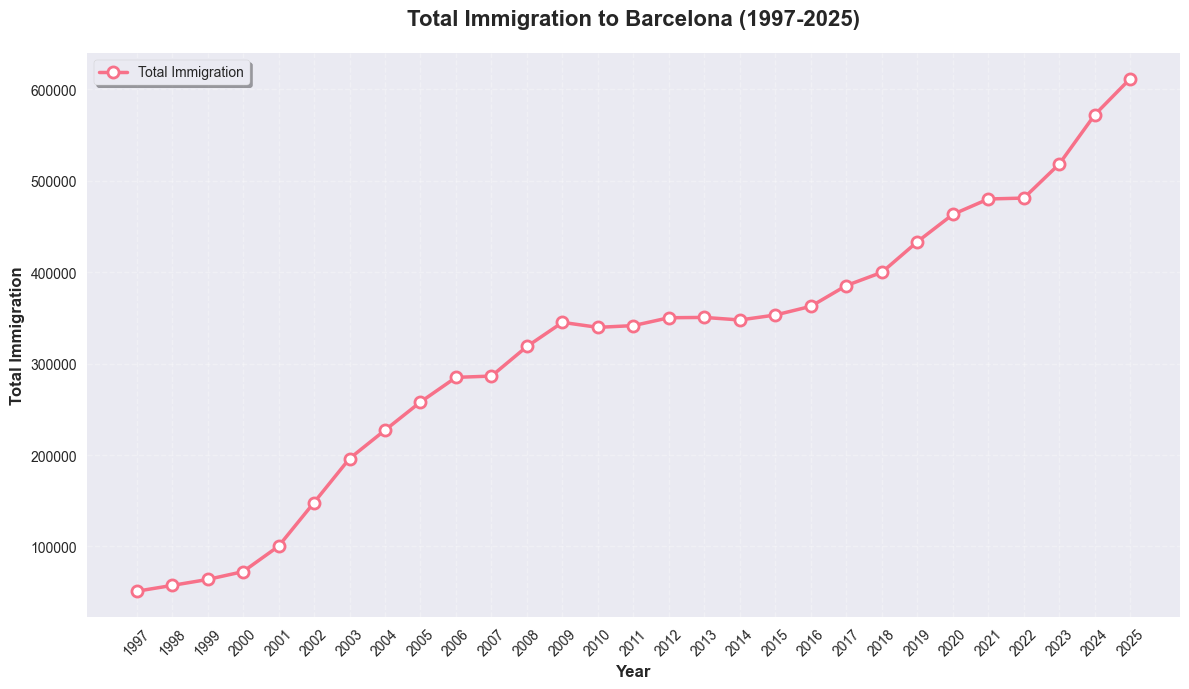

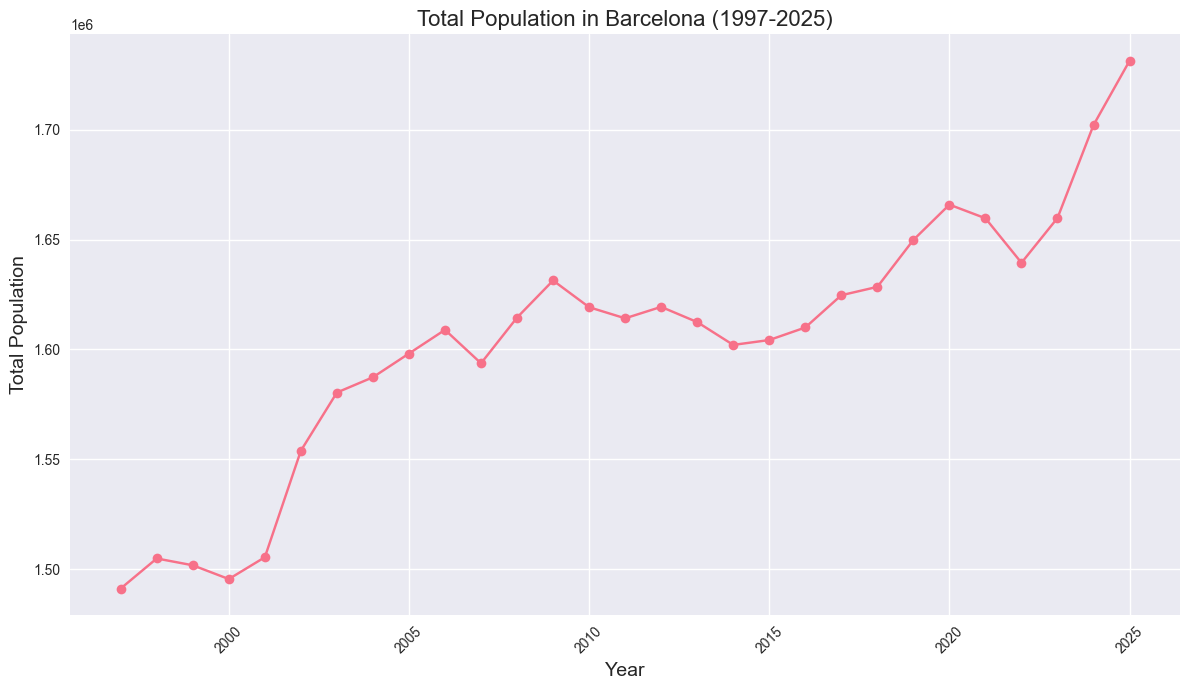

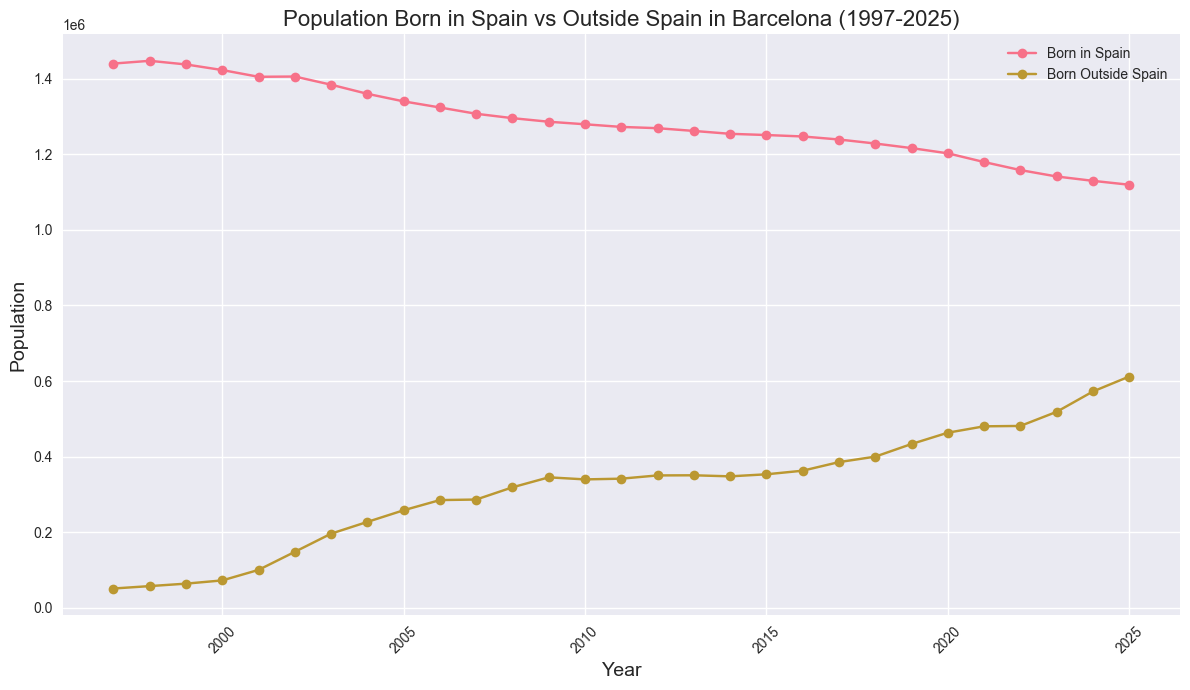

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
#dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'
dataPath_esp = '../data/processed/neighborhood_population_summary.csv'
#data_region = pd.read_csv(dataPath_region)
data_esp = pd.read_csv(dataPath_esp)

# Get total immigration by year in all Barcelona
total_immigration = data_esp.groupby('Year_Reference', as_index=False)['outside_spain'].sum().rename(columns={'outside_spain':'total_immigration'})

# Plot temporal series
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot with enhanced styling
ax.plot(total_immigration['Year_Reference'], 
        total_immigration['total_immigration'], 
        marker='o', 
        linewidth=2.5, 
        markersize=8,
        markerfacecolor='white',
        markeredgewidth=2,
        label='Total Immigration')

# Enhanced styling
ax.set_title('Total Immigration to Barcelona (1997-2025)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Immigration', fontsize=12, fontweight='bold')

# Improve grid and ticks
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(total_immigration['Year_Reference'])
ax.tick_params(axis='both', which='major', labelsize=10)

# Add some padding and rotate x-ticks if needed
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend if you have multiple lines
ax.legend(frameon=True, fancybox=True, shadow=True)

# Remove spines for cleaner look
sns.despine(left=True, bottom=True)

plt.savefig('../data/outputs/total_immigration_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

# Figure with total population over time in Barcelona
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Load data
dataPath_esp = '../data/processed/neighborhood_population_summary.csv'
data_esp = pd.read_csv(dataPath_esp)
# Aggregate
summary = data_esp.groupby('Year_Reference', as_index=False).agg({'total_population':'sum'})
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
ax.plot(summary['Year_Reference'], summary['total_population'], marker='o', linestyle='-')
ax.set_title('Total Population in Barcelona (1997-2025)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Population', fontsize=14)
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig('../data/outputs/total_population_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

# Population born in Spain vs Outside Spain over time in Barcelona
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Load data
dataPath_esp = '../data/processed/neighborhood_population_summary.csv'
data_esp = pd.read_csv(dataPath_esp)
# Aggregate
summary = data_esp.groupby('Year_Reference', as_index=False).agg({'spain_population':'sum',
                                                                  'outside_spain':'sum'})
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
ax.plot(summary['Year_Reference'], summary['spain_population'], marker='o', linestyle='-', label='Born in Spain')
ax.plot(summary['Year_Reference'], summary['outside_spain'], marker='o', linestyle='-', label='Born Outside Spain')
ax.set_title('Population Born in Spain vs Outside Spain in Barcelona (1997-2025)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Population', fontsize=14)
ax.grid(True)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig('../data/outputs/population_spain_vs_outside_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

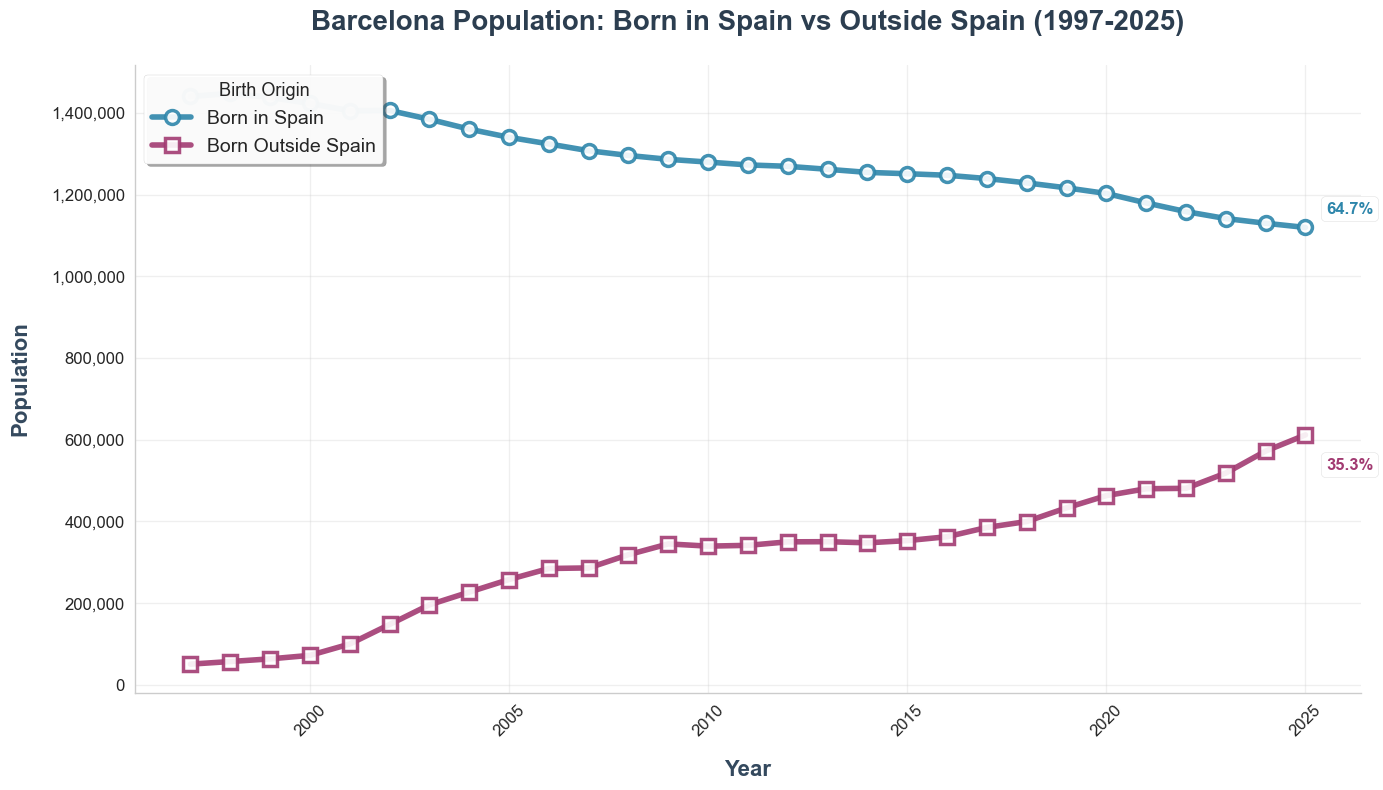

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set up professional colorblind-friendly palette
COLORS = ["#2E86AB", "#A23B72"]  # Professional blue and magenta
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(14, 8))

# Calculate percentages for annotations
summary['total_population'] = summary['spain_population'] + summary['outside_spain']
summary['spain_pct'] = (summary['spain_population'] / summary['total_population']) * 100
summary['outside_pct'] = (summary['outside_spain'] / summary['total_population']) * 100

# Plot with enhanced styling
ax.plot(summary['Year_Reference'], summary['spain_population'], 
        marker='o', linestyle='-', linewidth=4, markersize=10,
        label='Born in Spain', color=COLORS[0], alpha=0.9,
        markerfacecolor='white', markeredgewidth=2.5)

ax.plot(summary['Year_Reference'], summary['outside_spain'], 
        marker='s', linestyle='-', linewidth=4, markersize=10,
        label='Born Outside Spain', color=COLORS[1], alpha=0.9,
        markerfacecolor='white', markeredgewidth=2.5)

# Enhanced styling
ax.set_title('Barcelona Population: Born in Spain vs Outside Spain (1997-2025)', 
             fontsize=20, fontweight='bold', pad=25, color='#2C3E50')
ax.set_xlabel('Year', fontsize=16, fontweight='semibold', labelpad=15, color='#34495E')
ax.set_ylabel('Population', fontsize=16, fontweight='semibold', 
              labelpad=15, color='#34495E')

# Format y-axis with thousand separators
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Enhanced grid and ticks
ax.grid(True, alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=12)

# Enhanced legend
legend = ax.legend(fontsize=14, frameon=True, fancybox=True, 
                   shadow=True, framealpha=0.95, loc='upper left',
                   title='Birth Origin', title_fontsize=13)

# Remove top and right spines for cleaner look
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Add percentage annotations for latest year
latest_year = summary['Year_Reference'].max()
latest_data = summary[summary['Year_Reference'] == latest_year].iloc[0]

ax.annotate(f"{latest_data['spain_pct']:.1f}%", 
           xy=(latest_year, latest_data['spain_population']), 
           xytext=(15, 10), textcoords='offset points',
           fontsize=12, fontweight='bold', color=COLORS[0],
           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, edgecolor='lightgray'))

ax.annotate(f"{latest_data['outside_pct']:.1f}%", 
           xy=(latest_year, latest_data['outside_spain']), 
           xytext=(15, -25), textcoords='offset points',
           fontsize=12, fontweight='bold', color=COLORS[1],
           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9, edgecolor='lightgray'))

plt.xticks(rotation=45)
plt.tight_layout()

# Save with higher quality
plt.savefig('../data/outputs/population_spain_vs_outside_barcelona_enhanced.png', 
            dpi=300, bbox_inches='tight', facecolor='white', 
            transparent=False, edgecolor='none')
plt.show()

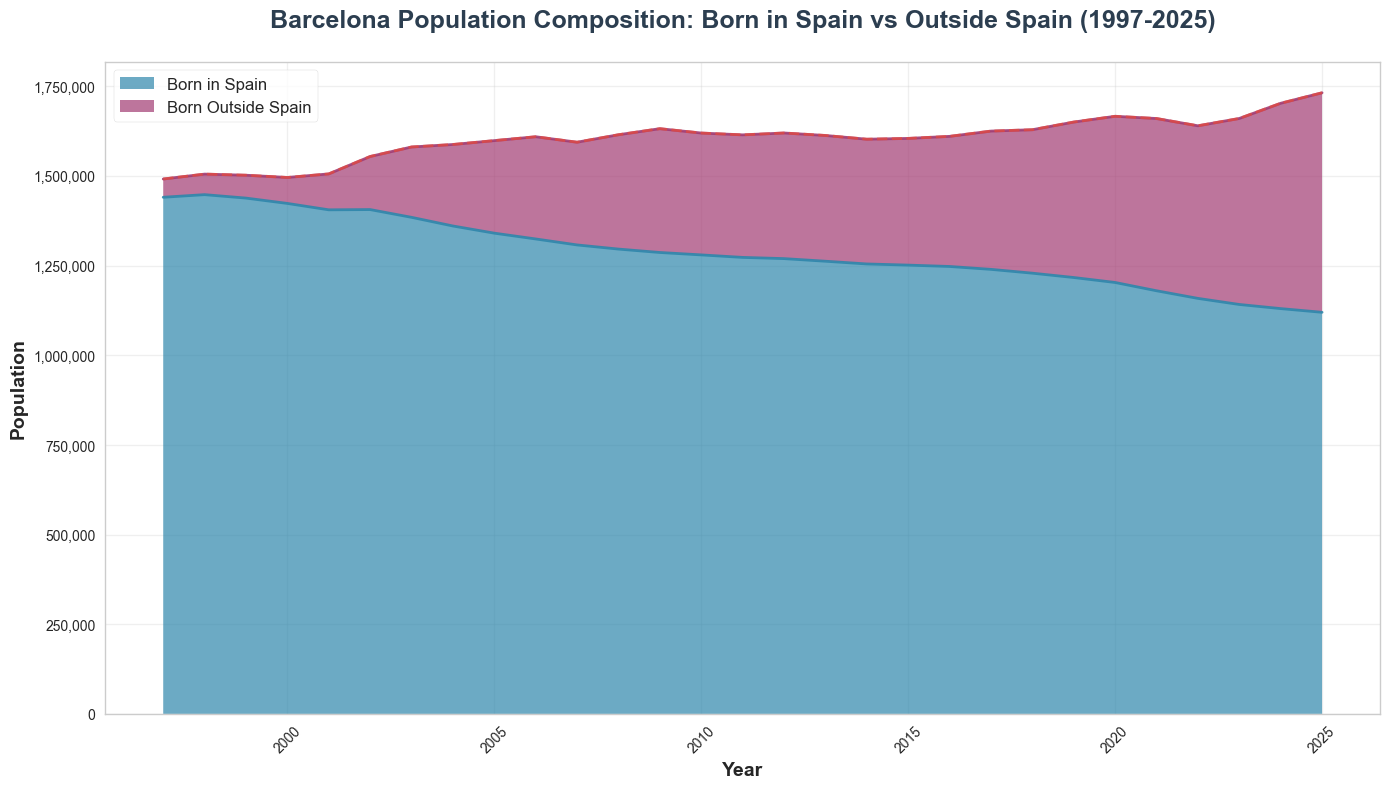

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create stacked area plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

# Colorblind-friendly colors
colors = ["#2E86AB", "#A23B72"]

# Stacked area plot
ax.stackplot(summary['Year_Reference'], 
             summary['spain_population'], 
             summary['outside_spain'],
             labels=['Born in Spain', 'Born Outside Spain'],
             colors=colors, alpha=0.7)

# Add line borders for clarity
ax.plot(summary['Year_Reference'], summary['spain_population'], 
        color=colors[0], linewidth=2, alpha=0.9)
ax.plot(summary['Year_Reference'], summary['outside_spain'] + summary['spain_population'], 
        color=colors[1], linewidth=2, alpha=0.9)

# Enhanced styling
ax.set_title('Barcelona Population Composition: Born in Spain vs Outside Spain (1997-2025)', 
             fontsize=18, fontweight='bold', pad=25, color='#2C3E50')
ax.set_xlabel('Year', fontsize=14, fontweight='semibold')
ax.set_ylabel('Population', fontsize=14, fontweight='semibold')

# Format y-axis
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

# Legend
ax.legend(fontsize=12, frameon=True, fancybox=True, loc='upper left')
ax.grid(True, alpha=0.3)

# Add total population line
ax.plot(summary['Year_Reference'], summary['spain_population'] + summary['outside_spain'], 
        color='#E74C3C', linewidth=2, linestyle='--', alpha=0.7, label='Total Population')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

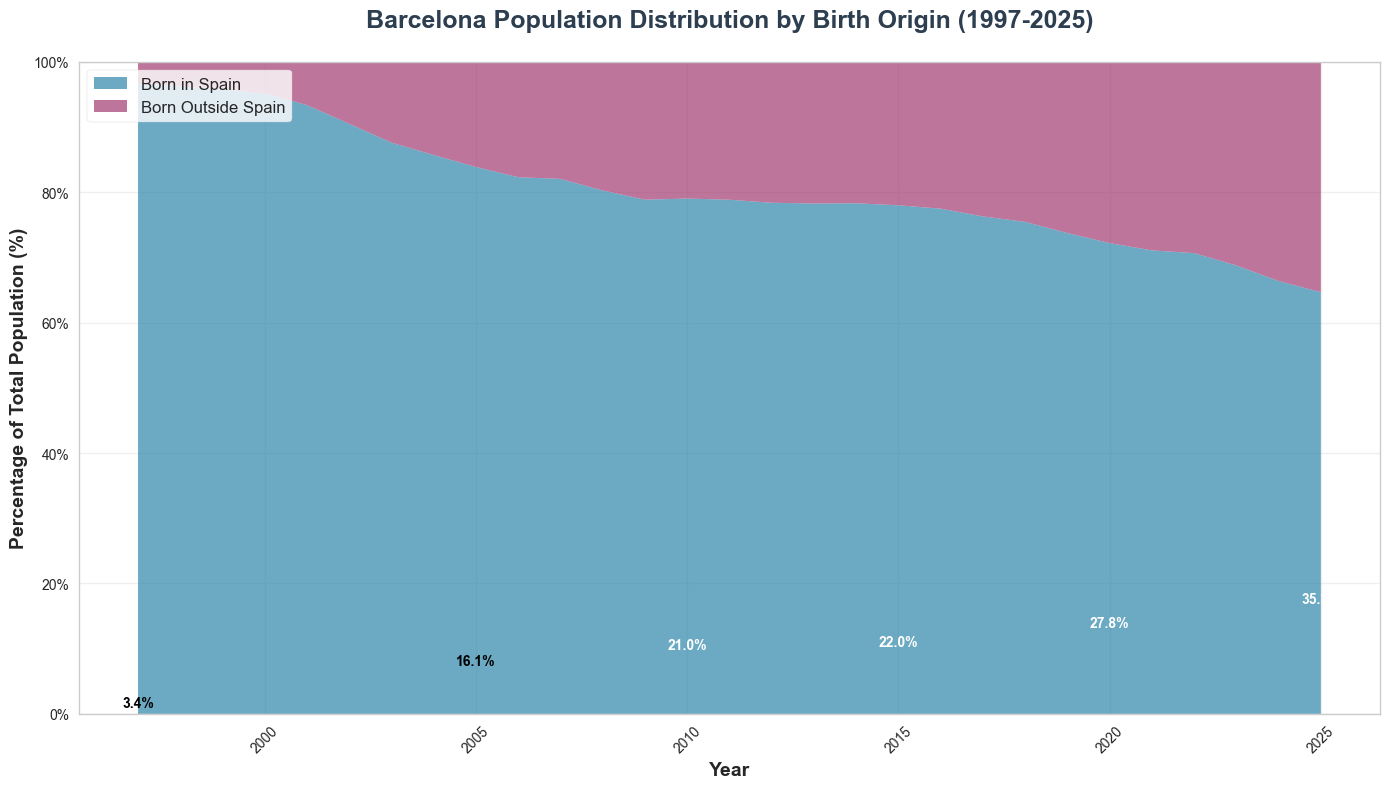

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate percentages
summary['spain_pct'] = (summary['spain_population'] / (summary['spain_population'] + summary['outside_spain'])) * 100
summary['outside_pct'] = (summary['outside_spain'] / (summary['spain_population'] + summary['outside_spain'])) * 100

# Create percentage area plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

colors = ["#2E86AB", "#A23B72"]

# 100% stacked area
ax.stackplot(summary['Year_Reference'], 
             summary['spain_pct'], 
             summary['outside_pct'],
             labels=['Born in Spain', 'Born Outside Spain'],
             colors=colors, alpha=0.7)

# Enhanced styling
ax.set_title('Barcelona Population Distribution by Birth Origin (1997-2025)', 
             fontsize=18, fontweight='bold', pad=25, color='#2C3E50')
ax.set_xlabel('Year', fontsize=14, fontweight='semibold')
ax.set_ylabel('Percentage of Total Population (%)', fontsize=14, fontweight='semibold')

# Set y-axis limits and format
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}%'))

# Add value annotations for key years
key_years = [1997, 2005, 2010, 2015, 2020, 2025]
for year in key_years:
    if year in summary['Year_Reference'].values:
        year_data = summary[summary['Year_Reference'] == year].iloc[0]
        ax.annotate(f"{year_data['outside_pct']:.1f}%", 
                   xy=(year, year_data['outside_pct']/2), 
                   xytext=(0, 0), textcoords='offset points',
                   ha='center', va='center', fontsize=10, fontweight='bold',
                   color='white' if year_data['outside_pct'] > 20 else 'black')

ax.legend(fontsize=12, frameon=True, fancybox=True, loc='upper left')
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

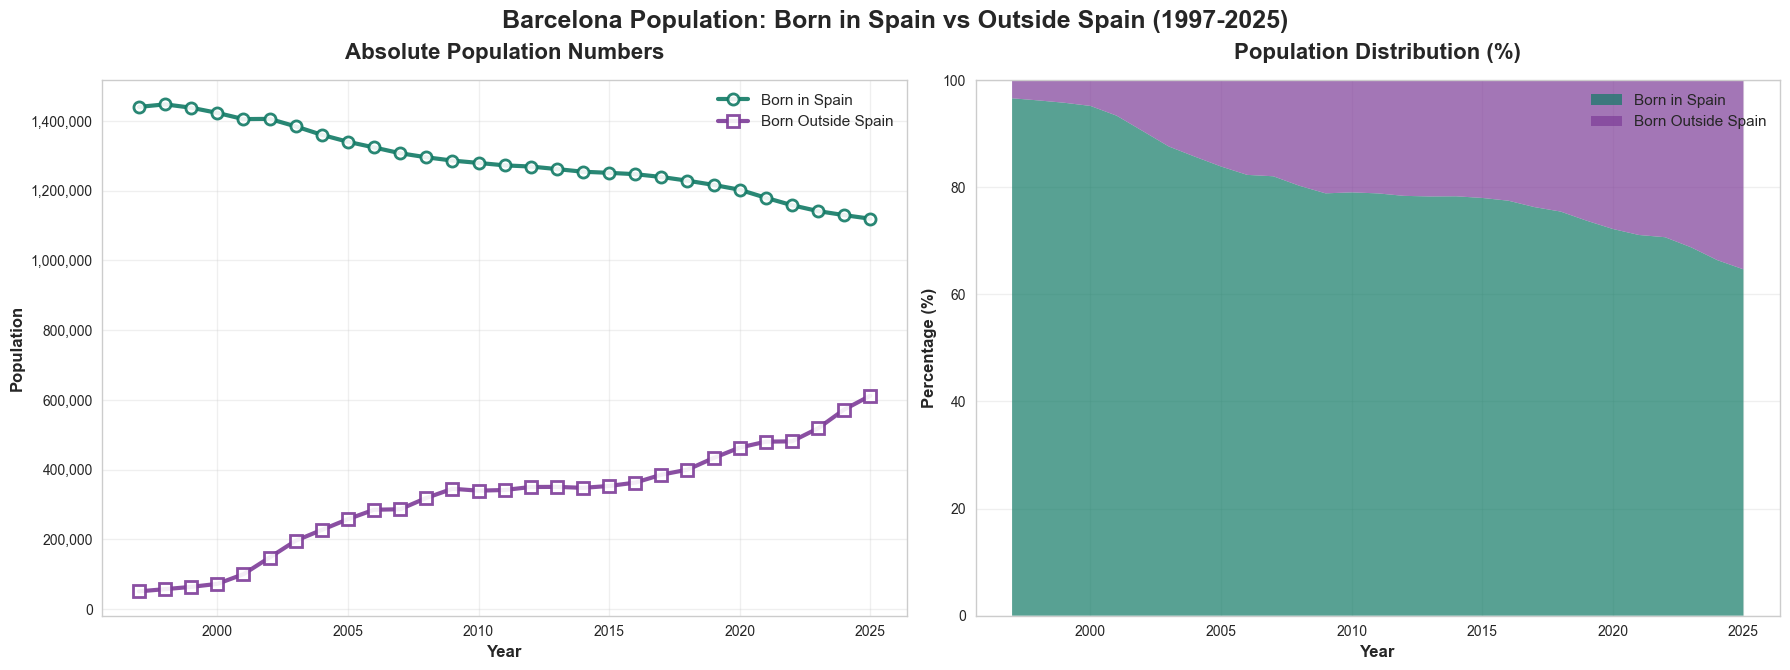

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create dual plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
#Colorblind-friendly  colors
colors = ["#117A65", "#7D3C98"]  # Green/Purple

# Left plot - Absolute values
ax1.plot(summary['Year_Reference'], summary['spain_population'], 
         marker='o', linestyle='-', linewidth=3, markersize=8,
         label='Born in Spain', color=colors[0], alpha=0.9,
         markerfacecolor='white', markeredgewidth=2)

ax1.plot(summary['Year_Reference'], summary['outside_spain'], 
         marker='s', linestyle='-', linewidth=3, markersize=8,
         label='Born Outside Spain', color=colors[1], alpha=0.9,
         markerfacecolor='white', markeredgewidth=2)

ax1.set_title('Absolute Population Numbers', fontsize=16, fontweight='bold', pad=15)
ax1.set_xlabel('Year', fontsize=12, fontweight='semibold')
ax1.set_ylabel('Population', fontsize=12, fontweight='semibold')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Right plot - Percentage composition
ax2.stackplot(summary['Year_Reference'], 
              summary['spain_pct'], 
              summary['outside_pct'],
              labels=['Born in Spain', 'Born Outside Spain'],
              colors=colors, alpha=0.7)

ax2.set_title('Population Distribution (%)', fontsize=16, fontweight='bold', pad=15)
ax2.set_xlabel('Year', fontsize=12, fontweight='semibold')
ax2.set_ylabel('Percentage (%)', fontsize=12, fontweight='semibold')
ax2.set_ylim(0, 100)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

# Main title
plt.suptitle('Barcelona Population: Born in Spain vs Outside Spain (1997-2025)', 
             fontsize=18, fontweight='bold', y=0.95)

plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Save figure
plt.savefig('../data/outputs/population_spain_vs_outside_dual_view.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

Interactive plot with plotly (See how to fix it)

In [59]:
# Interactive plot with Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create interactive plot
fig = px.line(total_immigration, 
              x='Year_Reference', 
              y='total_immigration',
              title='<b>Total Immigration to Barcelona (1997-2025)</b>',
              markers=True,
              template='plotly_white')

# Enhance the styling
fig.update_traces(line=dict(width=3, color='#1f77b4'),
                  marker=dict(size=8, 
                             line=dict(width=2, color='white')),
                  hovertemplate='<b>Year: %{x}</b><br>Immigration: %{y:,}<extra></extra>')

# Update layout
fig.update_layout(
    xaxis=dict(
        title='<b>Year</b>',
        tickangle=45,
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title='<b>Total Immigration</b>',
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    ),
    font=dict(
        family="Arial, sans-serif",
        size=12,
    ),
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Arial"
    ),
    width=1000,
    height=600
)

# Save as interactive HTML and static image
fig.write_html('../data/outputs/total_immigration_barcelona_interactive.html')
#fig.write_image('../data/outputs/total_immigration_barcelona_plotly.png', scale=2)
fig.show()

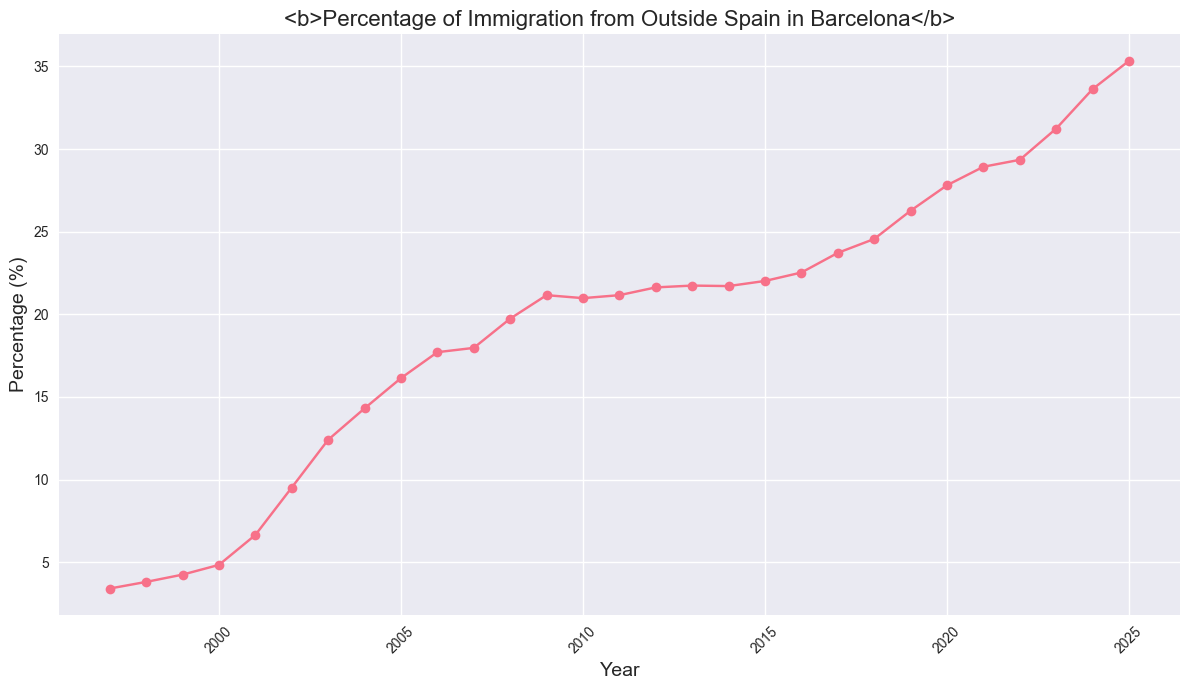

In [53]:
# Total percentage of immigration from outside Spain in Barcelona timeline plot 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
# Load data
dataPath_esp = '../data/processed/neighborhood_population_summary.csv'
data_esp = pd.read_csv(dataPath_esp)
# Aggregate
summary = data_esp.groupby('Year_Reference', as_index=False).agg({
    'total_population':'sum',
    'outside_spain':'sum'
})
summary['pct_outside_spain'] = (summary['outside_spain'] / summary['total_population'] * 100).round(2)
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
ax.plot(summary['Year_Reference'], summary['pct_outside_spain'], marker='o', linestyle='-')
ax.set_title('<b>Percentage of Immigration from Outside Spain in Barcelona</b>', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
plt.savefig('../data/outputs/pct_immigration_outside_spain_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()



### Population Growth: Case of East Asia and South America

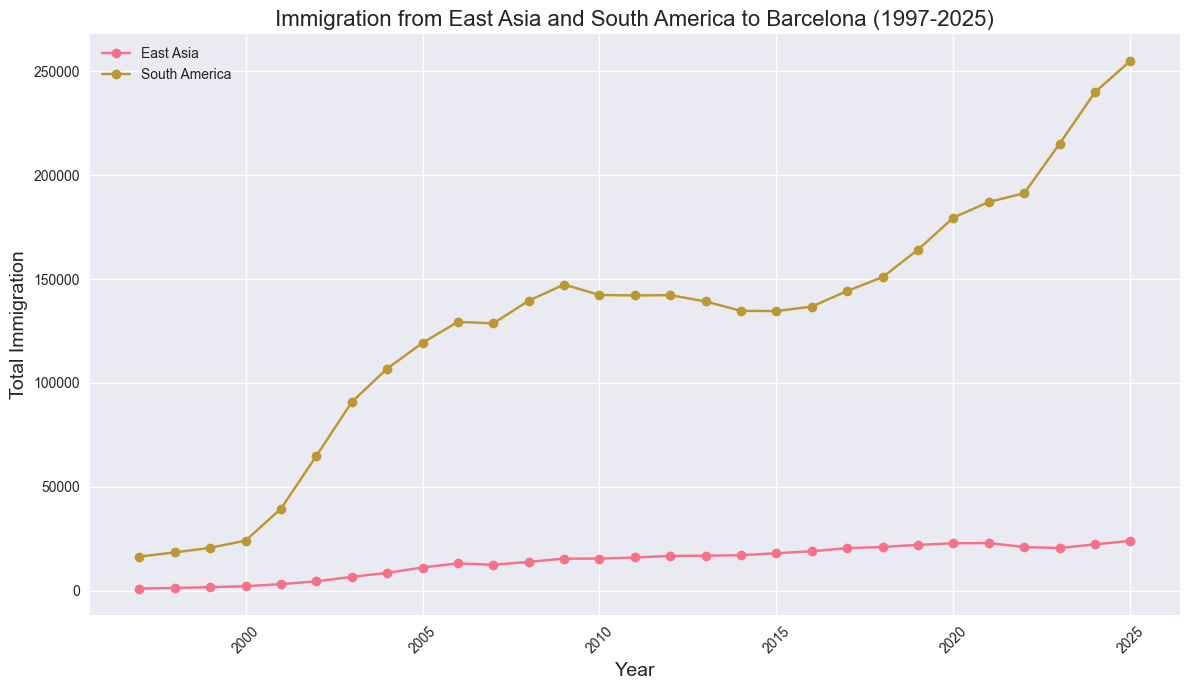

In [60]:
# Plot with immigration from East Asia and South America over time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Load data
dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'
data_region = pd.read_csv(dataPath_region)
# Filter for East Asia and South America
data_east_asia = data_region[data_region['Birth_Place_Region'] == 'Eastern Asia']
data_south_america = data_region[data_region['Birth_Place_Region'] == 'South America']
# Aggregate total immigration by year
east_asia_agg = data_east_asia.groupby('Year_Reference', as_index=False)['Value'].sum().rename(columns={'Value':'east_asia_immigration'})
south_america_agg = data_south_america.groupby('Year_Reference', as_index=False)['Value'].sum().rename(columns={'Value':'south_america_immigration'})
# Merge datasets
immigration_summary = east_asia_agg.merge(south_america_agg, on='Year_Reference', how='outer').fillna(0)
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
ax.plot(immigration_summary['Year_Reference'], immigration_summary['east_asia_immigration'], marker='o', linestyle='-', label='East Asia')
ax.plot(immigration_summary['Year_Reference'], immigration_summary['south_america_immigration'], marker='o', linestyle='-', label='South America')
ax.set_title('Immigration from East Asia and South America to Barcelona (1997-2025)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Immigration', fontsize=14)
ax.grid(True)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig('../data/outputs/immigration_east_asia_south_america_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

### Population Growth: Case of Southern Asia and Northern Africa

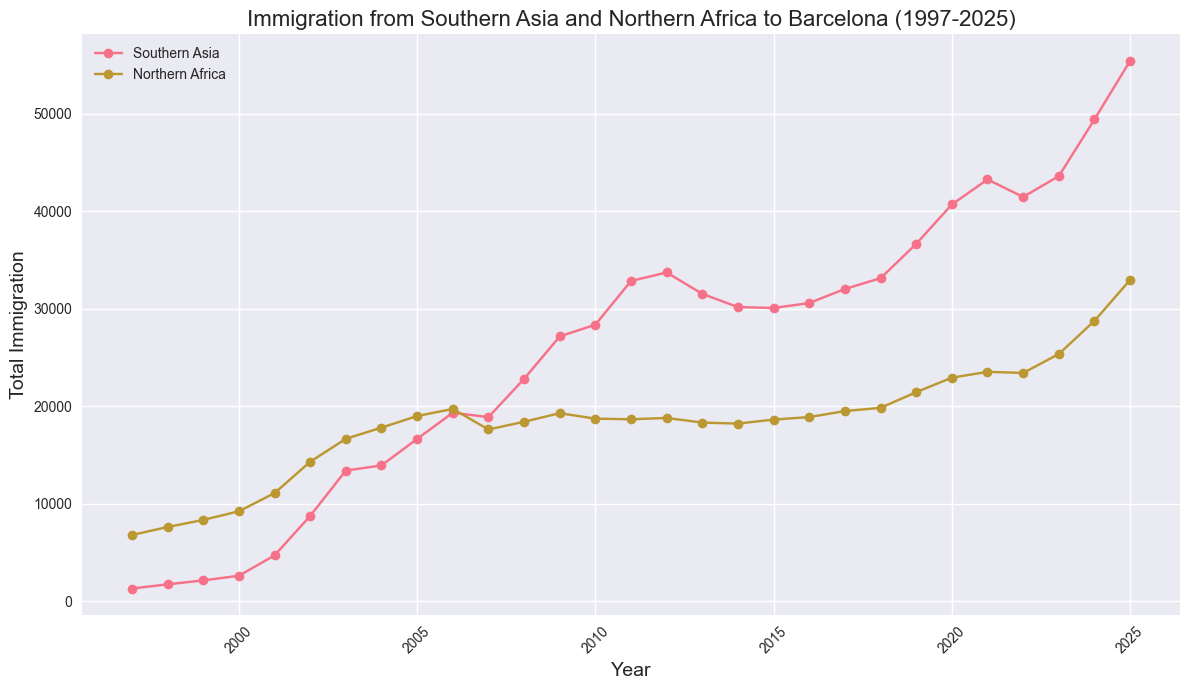

In [61]:
# Plot with immigration from East Asia and South America over time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Load data
dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'
data_region = pd.read_csv(dataPath_region)
# Filter for South Asia and North Africa
data_south_asia = data_region[data_region['Birth_Place_Region'] == 'Southern Asia']
data_north_africa = data_region[data_region['Birth_Place_Region'] == 'Northern Africa']
# Aggregate total immigration by year
south_asia_agg = data_south_asia.groupby('Year_Reference', as_index=False)['Value'].sum().rename(columns={'Value':'south_asia_immigration'})
north_africa_agg = data_north_africa.groupby('Year_Reference', as_index=False)['Value'].sum().rename(columns={'Value':'north_africa_immigration'})
# Merge datasets
immigration_summary = south_asia_agg.merge(north_africa_agg, on='Year_Reference', how='outer').fillna(0)
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
ax.plot(immigration_summary['Year_Reference'], immigration_summary['south_asia_immigration'], marker='o', linestyle='-', label='Southern Asia')
ax.plot(immigration_summary['Year_Reference'], immigration_summary['north_africa_immigration'], marker='o', linestyle='-', label='Northern Africa')
ax.set_title('Immigration from Southern Asia and Northern Africa to Barcelona (1997-2025)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Immigration', fontsize=14)
ax.grid(True)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig('../data/outputs/immigration_southern_asia_northern_africa_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

#### Join east asia, south asia and north africa

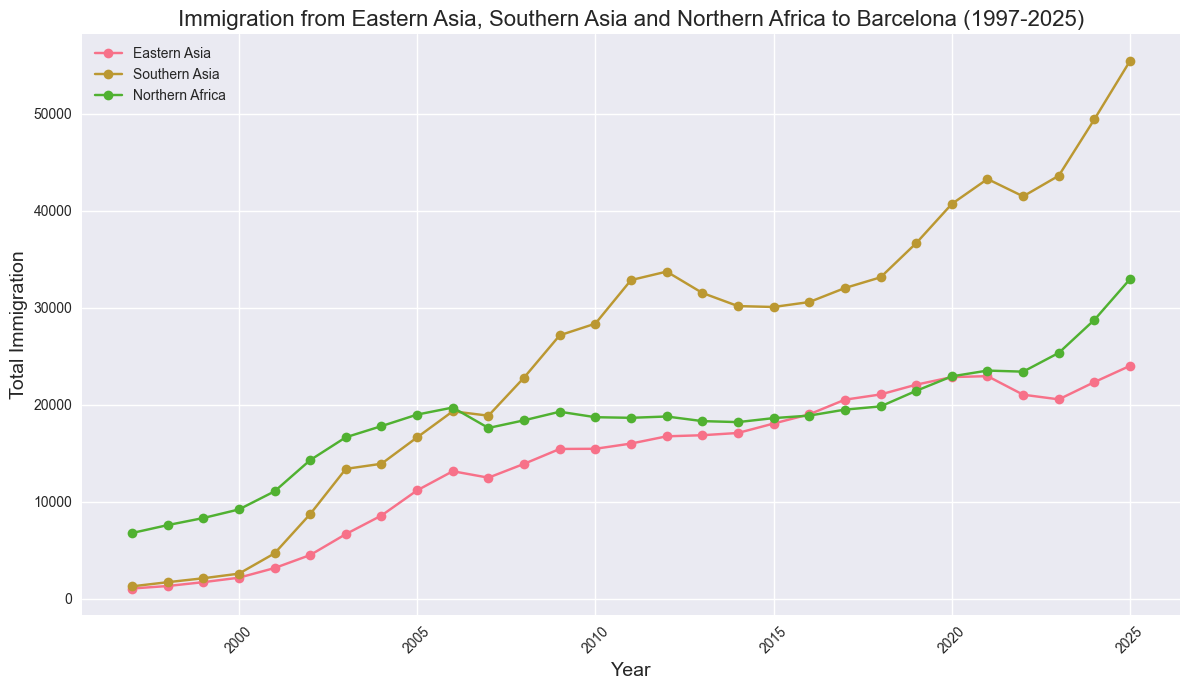

In [62]:
# Plot with immigration from East Asia and South America over time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Load data
dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'
data_region = pd.read_csv(dataPath_region)
# Filter for East Asia, South Asia and North Africa
data_east_asia = data_region[data_region['Birth_Place_Region'] == 'Eastern Asia']
data_south_asia = data_region[data_region['Birth_Place_Region'] == 'Southern Asia']
data_north_africa = data_region[data_region['Birth_Place_Region'] == 'Northern Africa']
# Aggregate total immigration by year
east_asia_agg = data_east_asia.groupby('Year_Reference', as_index=False)['Value'].sum().rename(columns={'Value':'east_asia_immigration'})
south_asia_agg = data_south_asia.groupby('Year_Reference', as_index=False)['Value'].sum().rename(columns={'Value':'south_asia_immigration'})
north_africa_agg = data_north_africa.groupby('Year_Reference', as_index=False)['Value'].sum().rename(columns={'Value':'north_africa_immigration'})
# Merge datasets
immigration_summary = east_asia_agg.merge(south_asia_agg, on='Year_Reference', how='outer').fillna(0)
immigration_summary = immigration_summary.merge(north_africa_agg, on='Year_Reference', how='outer').fillna(0)
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
ax.plot(immigration_summary['Year_Reference'], immigration_summary['east_asia_immigration'], marker='o', linestyle='-', label='Eastern Asia')
ax.plot(immigration_summary['Year_Reference'], immigration_summary['south_asia_immigration'], marker='o', linestyle='-', label='Southern Asia')
ax.plot(immigration_summary['Year_Reference'], immigration_summary['north_africa_immigration'], marker='o', linestyle='-', label='Northern Africa')
ax.set_title('Immigration from Eastern Asia, Southern Asia and Northern Africa to Barcelona (1997-2025)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Immigration', fontsize=14)
ax.grid(True)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig('../data/outputs/immigration_eastern_asia_southern_asia_northern_africa_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

## Immigration by Gender

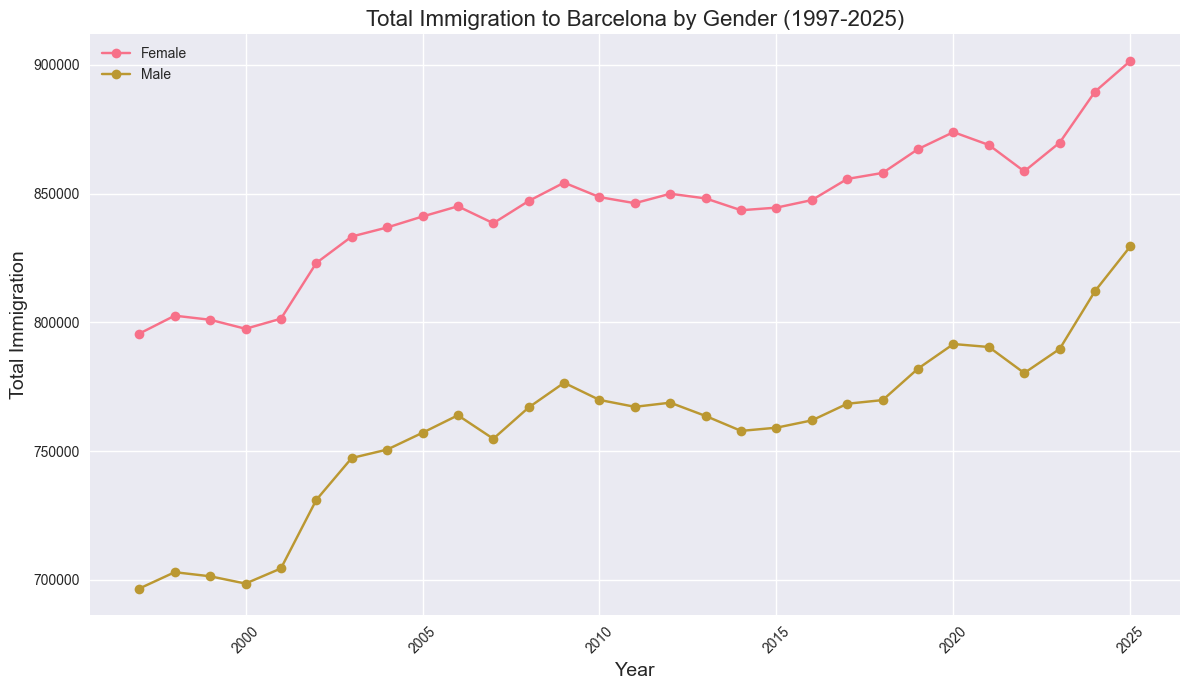

In [63]:
# Total Immigration to Barcelona from 1997 to 2025 by Gender
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Load data
dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'
data_region = pd.read_csv(dataPath_region)
# Aggregate total immigration by year and gender    
immigration_summary = data_region.groupby(['Year_Reference', 'Sex'], as_index=False)['Value'].sum().rename(columns={'Value':'total_immigration'})
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
for sex in immigration_summary['Sex'].unique():
    subset = immigration_summary[immigration_summary['Sex'] == sex]
    ax.plot(subset['Year_Reference'], subset['total_immigration'], marker='o', linestyle='-', label=sex)
ax.set_title('Total Immigration to Barcelona by Gender (1997-2025)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Immigration', fontsize=14)
ax.grid(True)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig('../data/outputs/total_immigration_by_gender_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

#### Immigration by Gender: Eastern Asia

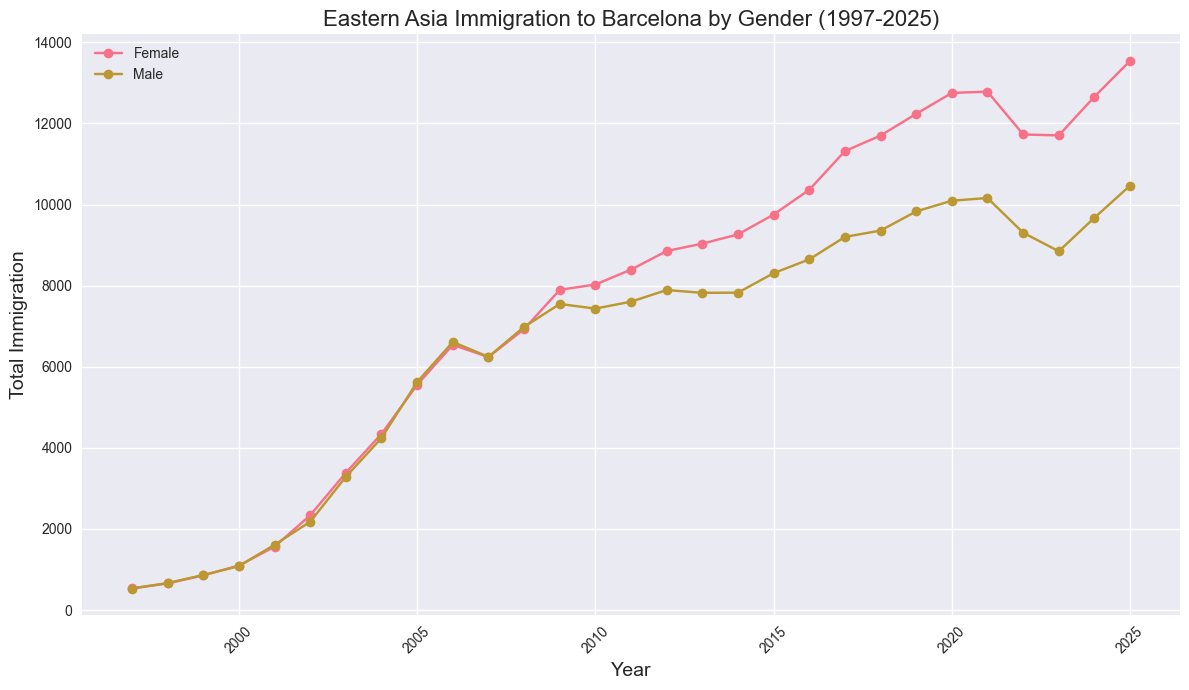

In [23]:
# Load data
dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'
data_region = pd.read_csv(dataPath_region)
# Filter only Eastern Asia
data_east_asia = data_region[data_region['Birth_Place_Region'] == 'Eastern Asia']

immigration_summary = data_east_asia.groupby(['Year_Reference', 'Sex'], as_index=False)['Value'].sum().rename(columns={'Value':'total_immigration'})
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
for sex in immigration_summary['Sex'].unique():
    subset = immigration_summary[immigration_summary['Sex'] == sex]
    ax.plot(subset['Year_Reference'], subset['total_immigration'], marker='o', linestyle='-', label=sex)
ax.set_title('Eastern Asia Immigration to Barcelona by Gender (1997-2025)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Immigration', fontsize=14)
ax.grid(True)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig('../data/outputs/east_asia_immigration_by_gender_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

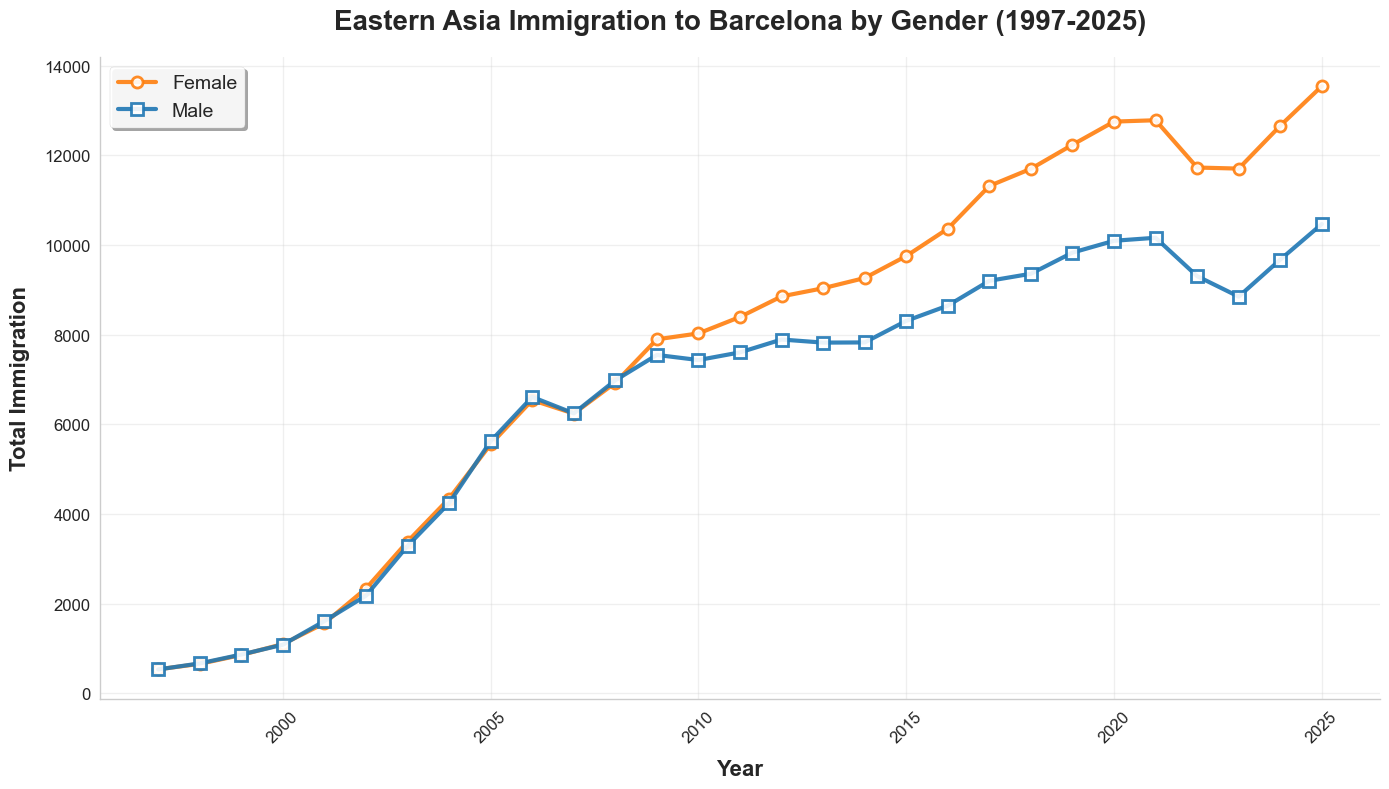

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set up colorblind-friendly palette
COLORS = ["#ff7f0e", "#1f77b4", "#2ca02c"]  # Blue, Orange, Green - colorblind safe

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(COLORS)

fig, ax = plt.subplots(figsize=(14, 8))

# Plot with enhanced styling
for i, sex in enumerate(immigration_summary['Sex'].unique()):
    subset = immigration_summary[immigration_summary['Sex'] == sex]
    ax.plot(subset['Year_Reference'], subset['total_immigration'], 
            marker=['o', 's'][i], linestyle='-', linewidth=3, markersize=8,
            label=sex, alpha=0.9, markerfacecolor='white', markeredgewidth=2)

# Enhanced styling
ax.set_title('Eastern Asia Immigration to Barcelona by Gender (1997-2025)', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=16, fontweight='semibold', labelpad=10)
ax.set_ylabel('Total Immigration', fontsize=16, fontweight='semibold', labelpad=10)

# Improve ticks and grid
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, alpha=0.3)
ax.set_axisbelow(True)

# Legend with enhanced styling
legend = ax.legend(fontsize=14, frameon=True, fancybox=True, 
                   shadow=True, framealpha=0.9, loc='best')

# Remove spines for cleaner look
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.xticks(rotation=45)
plt.tight_layout()

# Save with higher quality
plt.savefig('../data/outputs/east_asia_immigration_by_gender_barcelona_enhanced.png', 
            dpi=300, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

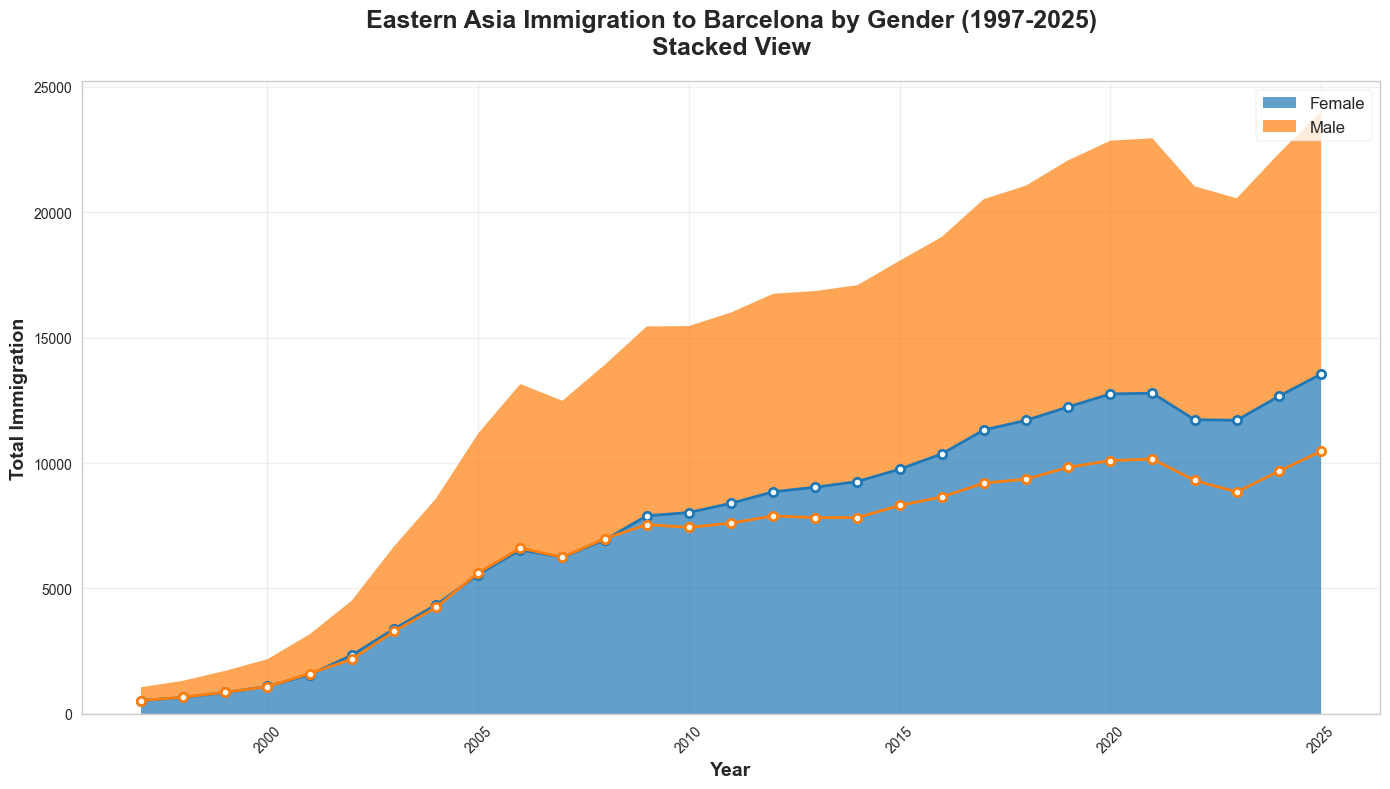

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot data for area plot
pivot_data = immigration_summary.pivot(index='Year_Reference', 
                                      columns='Sex', 
                                      values='total_immigration')

# Create stacked area plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

# Colorblind-friendly colors with transparency
colors = ["#1f77b4", "#ff7f0e"]

ax.stackplot(pivot_data.index, pivot_data.T, 
             labels=pivot_data.columns,
             colors=colors, alpha=0.7)

# Add line borders for clarity
for i, sex in enumerate(pivot_data.columns):
    ax.plot(pivot_data.index, pivot_data[sex], 
            color=colors[i], linewidth=2, marker='o', markersize=6,
            markerfacecolor='white', markeredgecolor=colors[i], markeredgewidth=2)

ax.set_title('Eastern Asia Immigration to Barcelona by Gender (1997-2025)\nStacked View', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=14, fontweight='semibold')
ax.set_ylabel('Total Immigration', fontsize=14, fontweight='semibold')
ax.legend(fontsize=12, frameon=True, fancybox=True)
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

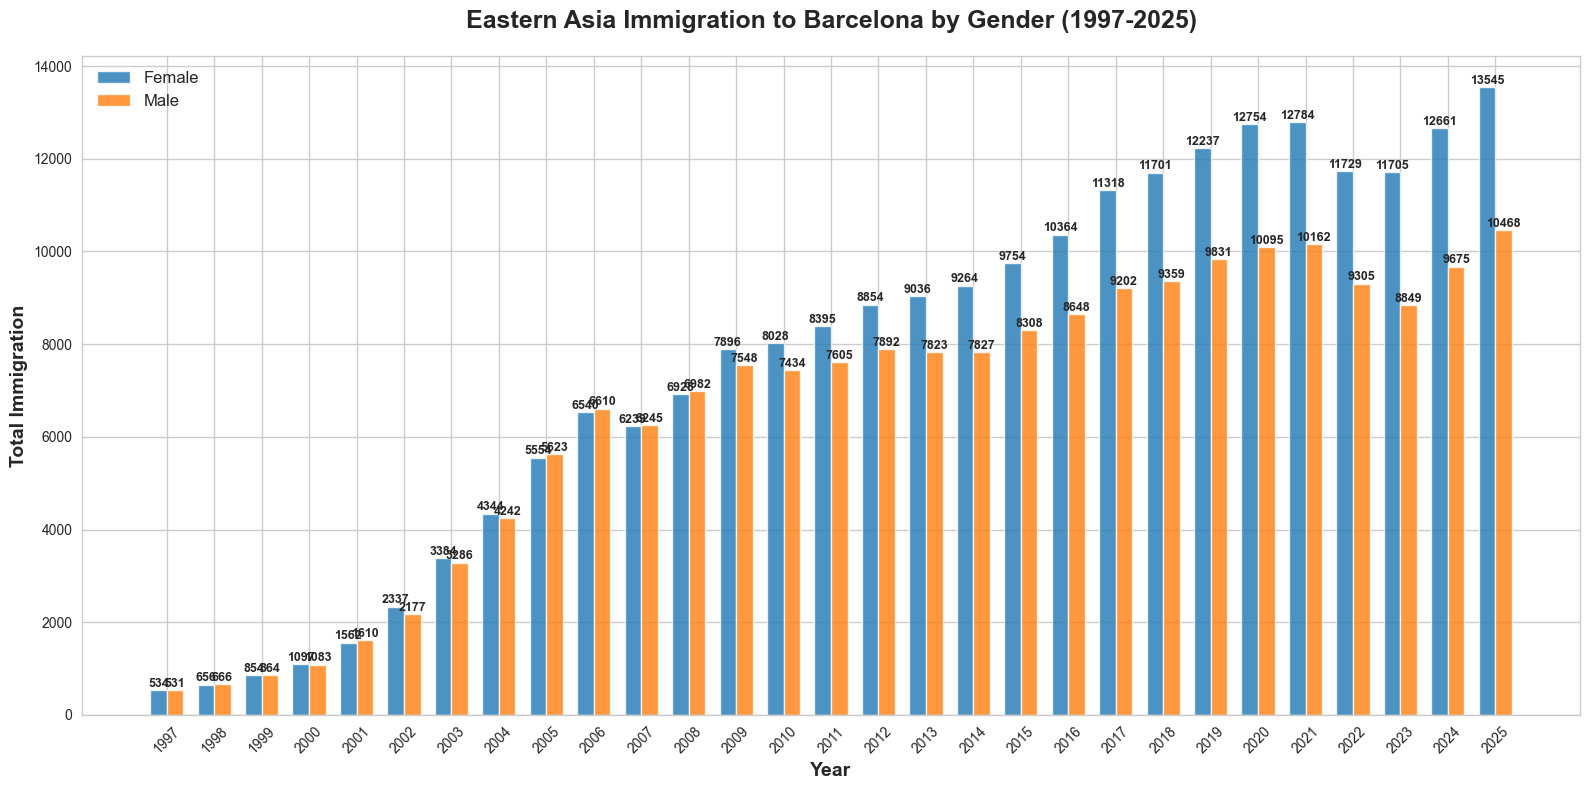

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create grouped bar plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 8))

# Colorblind-friendly palette
colors = ["#1f77b4", "#ff7f0e"]

# Create bar plot
bar_width = 0.35
x_pos = np.arange(len(immigration_summary['Year_Reference'].unique()))
years = sorted(immigration_summary['Year_Reference'].unique())

for i, sex in enumerate(immigration_summary['Sex'].unique()):
    subset = immigration_summary[immigration_summary['Sex'] == sex]
    values = [subset[subset['Year_Reference'] == year]['total_immigration'].values[0] 
              for year in years]
    
    ax.bar(x_pos + (i * bar_width), values, bar_width, 
            label=sex, color=colors[i], alpha=0.8, edgecolor='white', linewidth=1)

ax.set_title('Eastern Asia Immigration to Barcelona by Gender (1997-2025)', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=14, fontweight='semibold')
ax.set_ylabel('Total Immigration', fontsize=14, fontweight='semibold')
ax.set_xticks(x_pos + bar_width / 2)
ax.set_xticklabels(years, rotation=45)
ax.legend(fontsize=12)

# Add value labels on bars
for i, sex in enumerate(immigration_summary['Sex'].unique()):
    subset = immigration_summary[immigration_summary['Sex'] == sex]
    for j, year in enumerate(years):
        value = subset[subset['Year_Reference'] == year]['total_immigration'].values[0]
        if value > 0:  # Only label if value is significant
            ax.text(j + (i * bar_width), value + 5, f'{int(value)}', 
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [6]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create interactive plot with Plotly
fig = go.Figure()

# Colorblind-friendly colors
colors = ['#1f77b4', '#ff7f0e']

for i, sex in enumerate(immigration_summary['Sex'].unique()):
    subset = immigration_summary[immigration_summary['Sex'] == sex]
    
    fig.add_trace(go.Scatter(
        x=subset['Year_Reference'],
        y=subset['total_immigration'],
        mode='lines+markers',
        name=sex,
        line=dict(width=4, color=colors[i]),
        marker=dict(size=8, color=colors[i], 
                   line=dict(width=2, color='white')),
        hovertemplate=f"<b>{sex}</b><br>" +
                     "Year: %{x}<br>" +
                     "Immigrants: %{y:,}<br>" +
                     "<extra></extra>"
    ))

# Update layout for presentation
fig.update_layout(
    title=dict(
        text='<b>Eastern Asia Immigration to Barcelona by Gender (1997-2025)</b>',
        x=0.5,
        font=dict(size=24)
    ),
    xaxis=dict(
        title='<b>Year</b>',
        title_font=dict(size=16),
        tickfont=dict(size=12)
    ),
    yaxis=dict(
        title='<b>Total Immigration</b>',
        title_font=dict(size=16),
        tickfont=dict(size=12)
    ),
    legend=dict(
        font=dict(size=14),
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='rgba(0,0,0,0.2)',
        borderwidth=1
    ),
    plot_bgcolor='white',
    width=1000,
    height=600,
    hovermode='x unified'
)

fig.show()

#### Immigration by Gender: South America

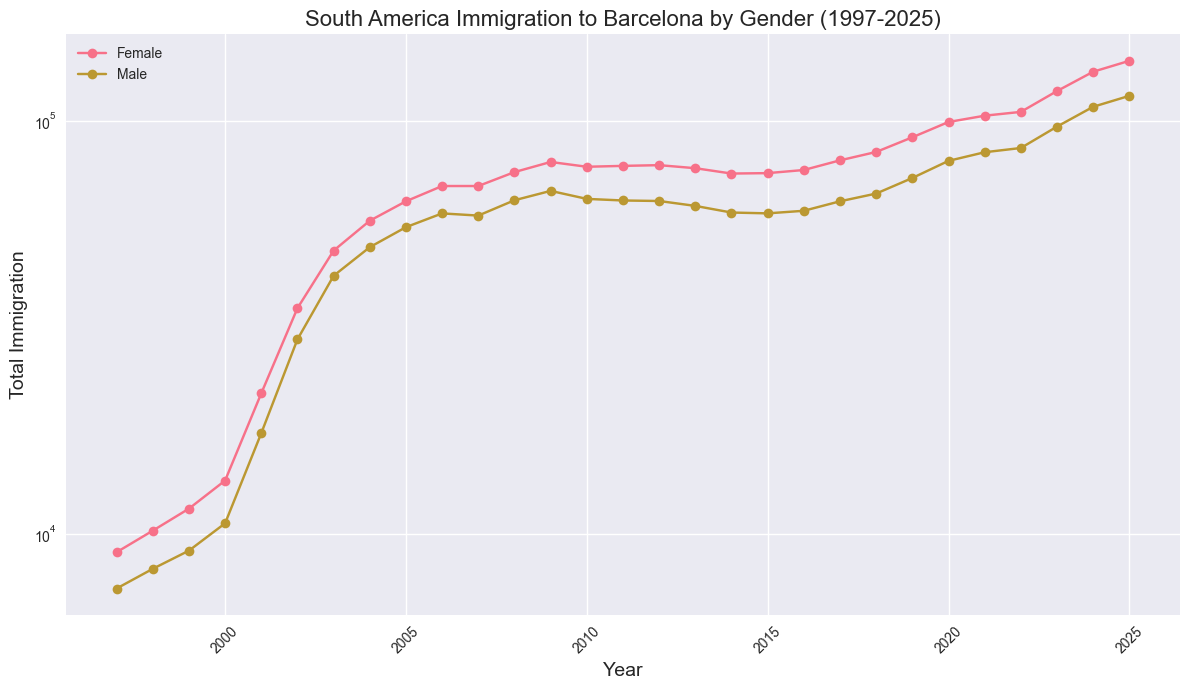

In [7]:
# Load data
dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'
data_region = pd.read_csv(dataPath_region)
# Filter only South America
data_south_america = data_region[data_region['Birth_Place_Region'] == 'South America']

immigration_summary = data_south_america.groupby(['Year_Reference', 'Sex'], as_index=False)['Value'].sum().rename(columns={'Value':'total_immigration'})
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
for sex in immigration_summary['Sex'].unique():
    subset = immigration_summary[immigration_summary['Sex'] == sex]
    ax.plot(subset['Year_Reference'], subset['total_immigration'], marker='o', linestyle='-', label=sex)
ax.set_title('South America Immigration to Barcelona by Gender (1997-2025)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Immigration', fontsize=14)
ax.set_yscale('log')
ax.grid(True)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig('../data/outputs/south_america_immigration_by_gender_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

#### Immigration by Gender: South Asia

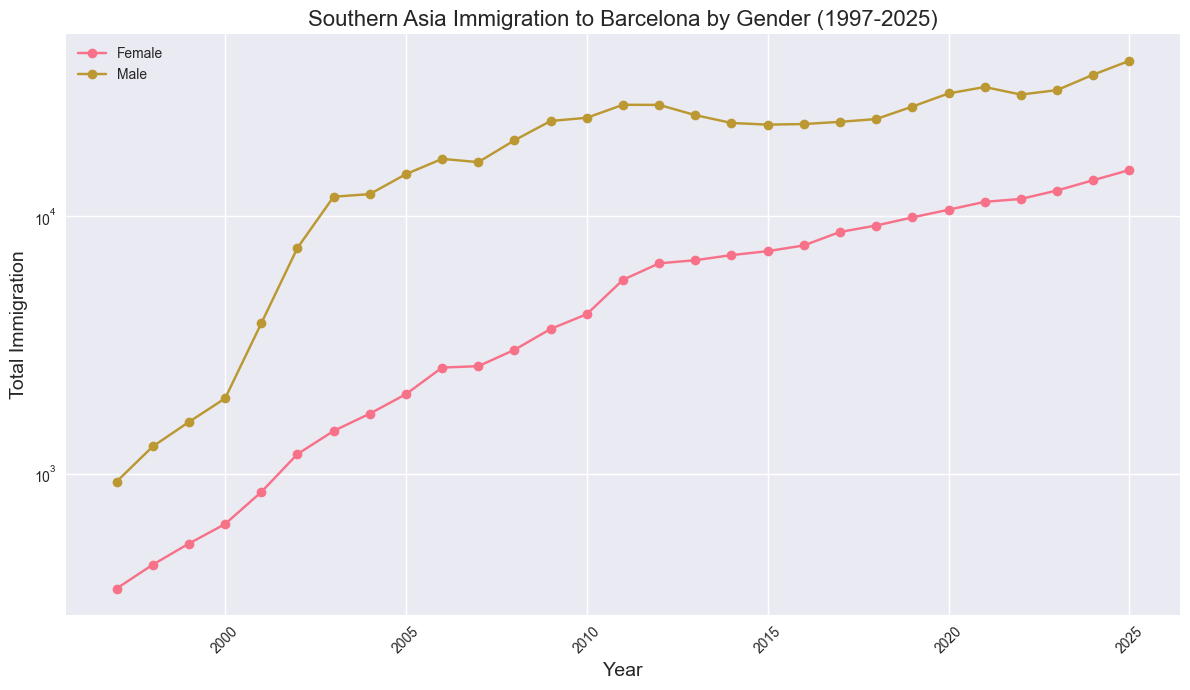

In [31]:
# Load data
dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'
data_region = pd.read_csv(dataPath_region)
# Filter only South Asia
data_south_asia = data_region[data_region['Birth_Place_Region'] == 'Southern Asia']

immigration_summary = data_south_asia.groupby(['Year_Reference', 'Sex'], as_index=False)['Value'].sum().rename(columns={'Value':'total_immigration'})
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
for sex in immigration_summary['Sex'].unique():
    subset = immigration_summary[immigration_summary['Sex'] == sex]
    ax.plot(subset['Year_Reference'], subset['total_immigration'], marker='o', linestyle='-', label=sex)
ax.set_title('Southern Asia Immigration to Barcelona by Gender (1997-2025)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Immigration', fontsize=14)
ax.set_yscale('log')
ax.grid(True)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig('../data/outputs/southern_asia_immigration_by_gender_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

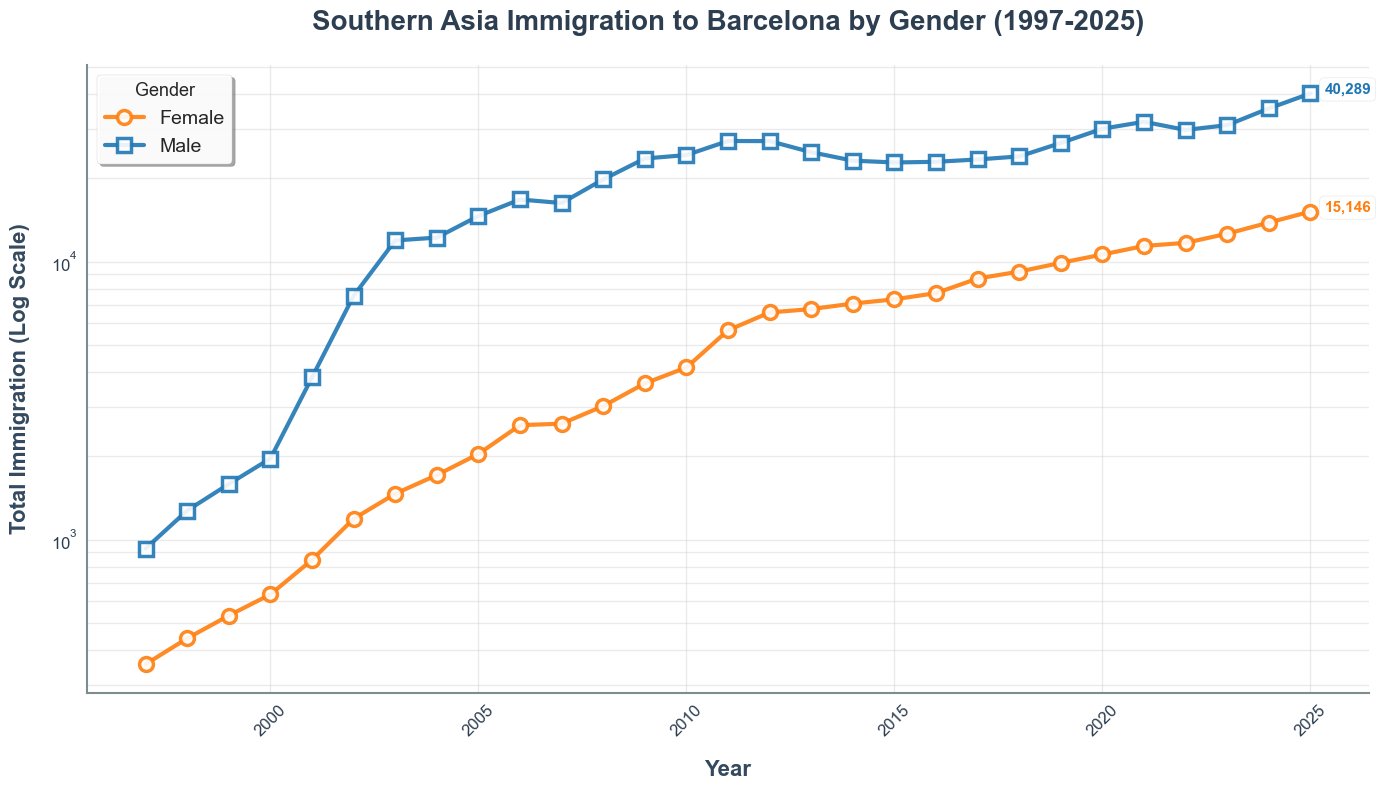

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'
data_region = pd.read_csv(dataPath_region)
# Filter only Southern Asia
data_southern_asia = data_region[data_region['Birth_Place_Region'] == 'Southern Asia']

immigration_summary = data_southern_asia.groupby(['Year_Reference', 'Sex'], as_index=False)['Value'].sum().rename(columns={'Value':'total_immigration'})

# Set up professional colorblind-friendly palette
COLORS = ["#ff7f0e", "#1f77b4", "#2ca02c"]  # Blue, Orange, Green - colorblind safe

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(COLORS)

fig, ax = plt.subplots(figsize=(14, 8))

# Plot with enhanced styling
for i, sex in enumerate(immigration_summary['Sex'].unique()):
    subset = immigration_summary[immigration_summary['Sex'] == sex]
    ax.plot(subset['Year_Reference'], subset['total_immigration'], 
            marker=['o', 's'][i], linestyle='-', linewidth=3, markersize=10,
            label=sex, alpha=0.9, markerfacecolor='white', markeredgewidth=2.5,
            markeredgecolor=COLORS[i])

# Enhanced styling
ax.set_title('Southern Asia Immigration to Barcelona by Gender (1997-2025)', 
             fontsize=20, fontweight='bold', pad=25, color='#2C3E50')
ax.set_xlabel('Year', fontsize=16, fontweight='semibold', labelpad=15, color='#34495E')
ax.set_ylabel('Total Immigration (Log Scale)', fontsize=16, fontweight='semibold', 
              labelpad=15, color='#34495E')

# Log scale with better formatting
ax.set_yscale('log')
ax.grid(True, alpha=0.4, which='both')

# Improve ticks
ax.tick_params(axis='both', which='major', labelsize=12, colors='#2C3E50')
ax.tick_params(axis='both', which='minor', labelsize=10)

# Enhanced legend
legend = ax.legend(fontsize=14, frameon=True, fancybox=True, 
                   shadow=True, framealpha=0.95, loc='upper left',
                   title='Gender', title_fontsize=13)

# Remove top and right spines for cleaner look
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('#7F8C8D')
    ax.spines[spine].set_linewidth(1.5)

# Add data point labels for latest year
latest_year = immigration_summary['Year_Reference'].max()
for sex in immigration_summary['Sex'].unique():
    subset = immigration_summary[(immigration_summary['Sex'] == sex) & 
                                (immigration_summary['Year_Reference'] == latest_year)]
    if not subset.empty:
        value = subset['total_immigration'].values[0]
        ax.annotate(f'{value:,}', 
                   xy=(latest_year, value), 
                   xytext=(10, 0), textcoords='offset points',
                   fontsize=11, fontweight='bold', color=COLORS[list(immigration_summary['Sex'].unique()).index(sex)],
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8, edgecolor='lightgray'))

plt.xticks(rotation=45)
plt.tight_layout()

# Save with higher quality
plt.savefig('../data/outputs/southern_asia_immigration_by_gender_barcelona_enhanced.png', 
            dpi=300, bbox_inches='tight', facecolor='white', 
            transparent=False, edgecolor='none')
plt.show()

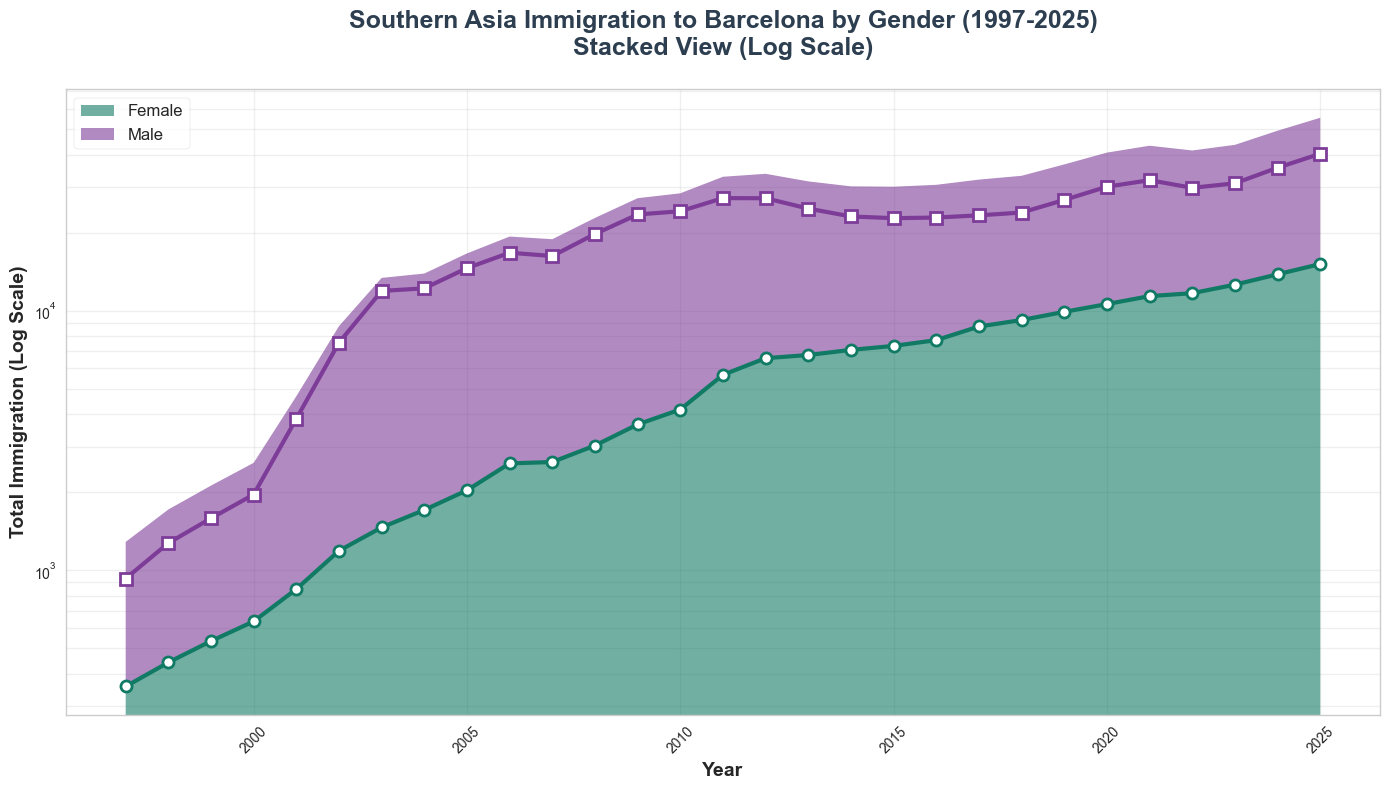

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pivot data for area plot
pivot_data = immigration_summary.pivot(index='Year_Reference', 
                                      columns='Sex', 
                                      values='total_immigration')

# Create stacked area plot on log scale
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

# Colorblind-friendly colors
colors = ["#117A65", "#7D3C98"]  # Green/Purple

# Create area plot
ax.stackplot(pivot_data.index, pivot_data.T, 
             labels=pivot_data.columns,
             colors=colors, alpha=0.6)

# Add line borders for clarity
for i, sex in enumerate(pivot_data.columns):
    ax.plot(pivot_data.index, pivot_data[sex], 
            color=colors[i], linewidth=3, marker=['o', 's'][i], markersize=8,
            markerfacecolor='white', markeredgecolor=colors[i], markeredgewidth=2)

# Set log scale
ax.set_yscale('log')

# Enhanced styling
ax.set_title('Southern Asia Immigration to Barcelona by Gender (1997-2025)\nStacked View (Log Scale)', 
             fontsize=18, fontweight='bold', pad=25, color='#2C3E50')
ax.set_xlabel('Year', fontsize=14, fontweight='semibold')
ax.set_ylabel('Total Immigration (Log Scale)', fontsize=14, fontweight='semibold')
ax.legend(fontsize=12, frameon=True, fancybox=True, loc='upper left')
ax.grid(True, alpha=0.3, which='both')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


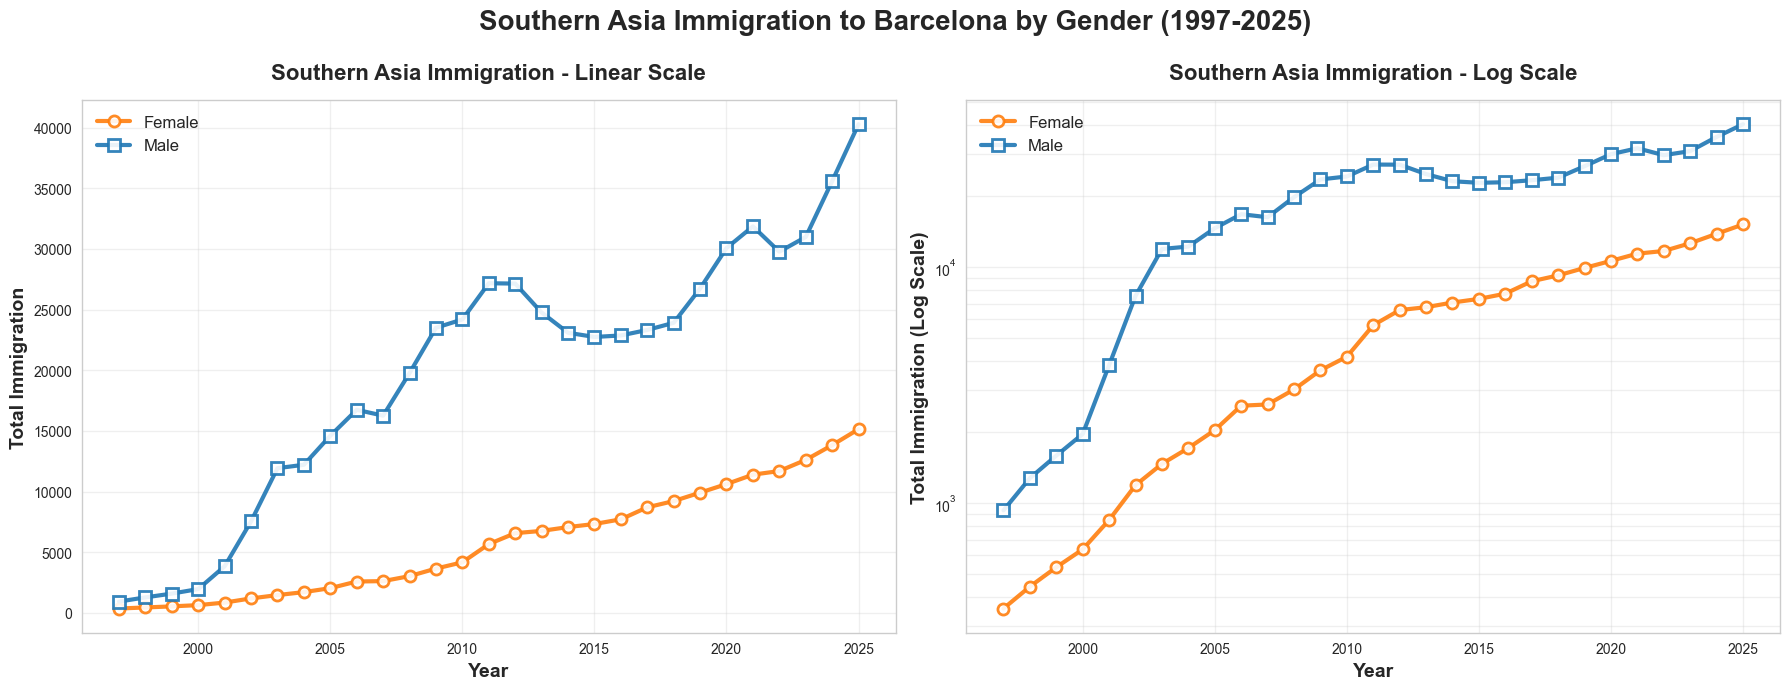

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplot comparison
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
# Set up professional colorblind-friendly palette
colors = ["#ff7f0e", "#1f77b4", "#2ca02c"]  # Blue, Orange, Green - colorblind safe

# Left subplot - Linear scale
for i, sex in enumerate(immigration_summary['Sex'].unique()):
    subset = immigration_summary[immigration_summary['Sex'] == sex]
    ax1.plot(subset['Year_Reference'], subset['total_immigration'], 
             marker=['o', 's'][i], linestyle='-', linewidth=3, markersize=8,
             label=sex, alpha=0.9, markerfacecolor='white', markeredgewidth=2,
             markeredgecolor=colors[i], color=colors[i])
ax1.set_title('Southern Asia Immigration - Linear Scale', 
              fontsize=16, fontweight='bold', pad=15)
ax1.set_xlabel('Year', fontsize=14, fontweight='semibold')
ax1.set_ylabel('Total Immigration', fontsize=14, fontweight='semibold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=12)

# Right subplot - Log scale
for i, sex in enumerate(immigration_summary['Sex'].unique()):
    subset = immigration_summary[immigration_summary['Sex'] == sex]
    ax2.plot(subset['Year_Reference'], subset['total_immigration'], 
             marker=['o', 's'][i], linestyle='-', linewidth=3, markersize=8,
             label=sex, alpha=0.9, markerfacecolor='white', markeredgewidth=2,
             markeredgecolor=colors[i], color=colors[i])

ax2.set_title('Southern Asia Immigration - Log Scale', 
              fontsize=16, fontweight='bold', pad=15)
ax2.set_xlabel('Year', fontsize=14, fontweight='semibold')
ax2.set_ylabel('Total Immigration (Log Scale)', fontsize=14, fontweight='semibold')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, which='both')
ax2.legend(fontsize=12)

# Main title
plt.suptitle('Southern Asia Immigration to Barcelona by Gender (1997-2025)', 
             fontsize=20, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Save figure
plt.savefig('../data/outputs/southern_asia_immigration_comparison.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

### Adoption

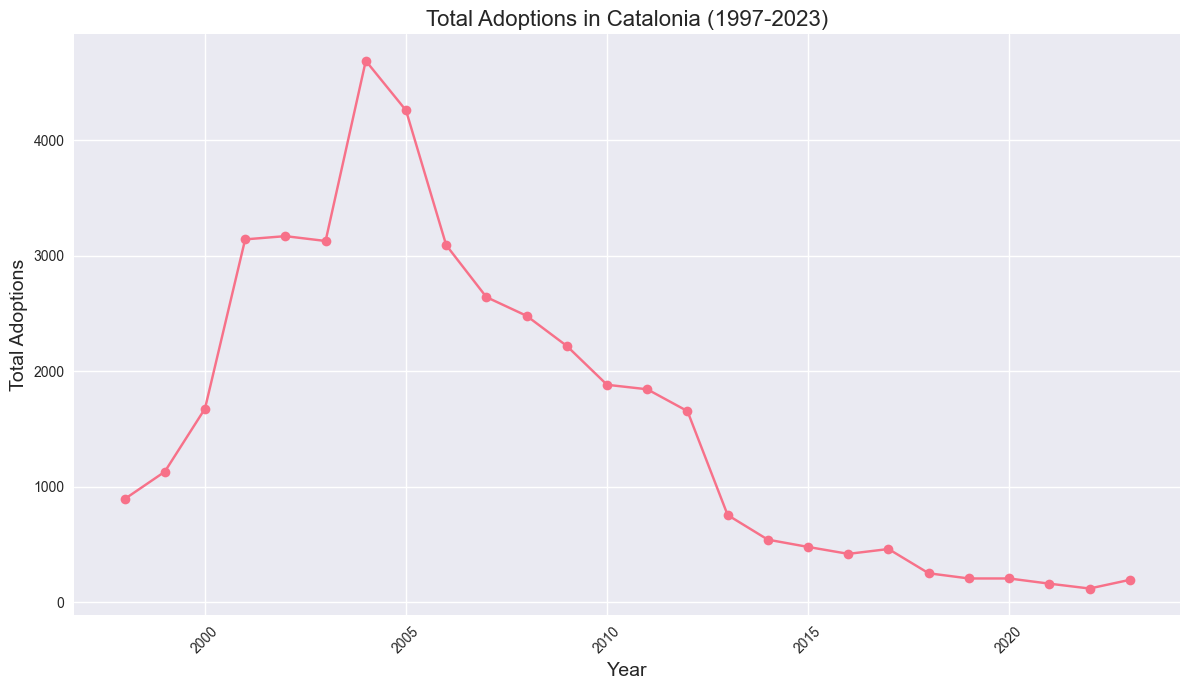

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Total adotion in Catalonia over time
adoption_data = pd.read_csv('../data/merged_data/merged_adoption_total.csv')
# Aggregate total adoptions by year
adoption_summary = adoption_data.groupby('Year', as_index=False)['Value'].sum().rename(columns={'Value':'total_adoptions'})
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
ax.plot(adoption_summary['Year'], adoption_summary['total_adoptions'], marker='o', linestyle='-')
ax.set_title('Total Adoptions in Catalonia (1997-2023)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Adoptions', fontsize=14)
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig('../data/outputs/total_adoptions_catalonia.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()


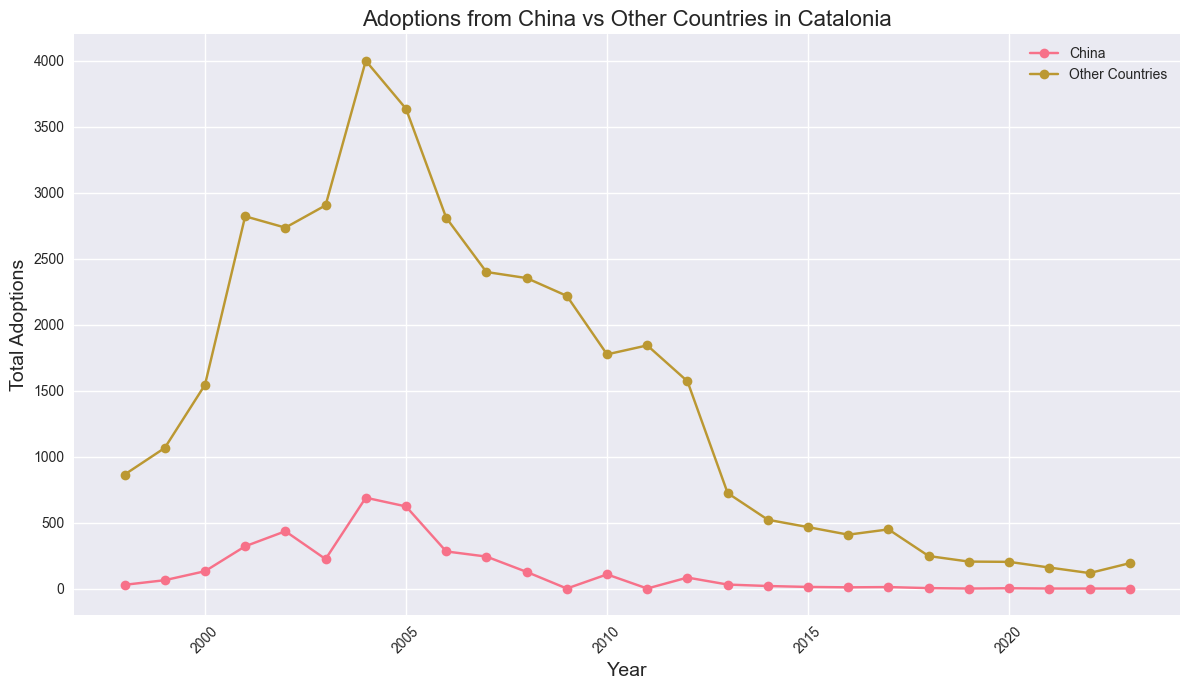

In [5]:
# ...existing code...
# Adoption from China vs Other Countries over time in Catalonia (fixed year parsing & normalization)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

adoption_data = pd.read_csv('../data/merged_data/merged_adoption_total.csv')

# Normalize Category (remove BOM/whitespace) and Year (force numeric)
adoption_data['Category'] = (
    adoption_data['Category']
    .astype(str)
    .str.replace('\ufeff', '', regex=False)
    .str.strip()
)
adoption_data['Year'] = pd.to_numeric(adoption_data['Year'], errors='coerce')
adoption_data = adoption_data.dropna(subset=['Year'])
adoption_data['Year'] = adoption_data['Year'].astype(int)

# Ensure Value numeric
adoption_data['Value'] = pd.to_numeric(adoption_data['Value'], errors='coerce').fillna(0).astype(int)

# Aggregate reliably (case-insensitive)
china_agg = (
    adoption_data[adoption_data['Category'].str.lower() == 'china']
    .groupby('Year', as_index=False)['Value']
    .sum()
    .rename(columns={'Value': 'china_adoptions'})
)
other_agg = (
    adoption_data[adoption_data['Category'].str.lower() != 'china']
    .groupby('Year', as_index=False)['Value']
    .sum()
    .rename(columns={'Value': 'other_adoptions'})
)

# Build full year range to avoid missing years (and fill zeros)
years = np.arange(adoption_data['Year'].min(), adoption_data['Year'].max() + 1)
adoption_summary = pd.DataFrame({'Year': years}) \
    .merge(china_agg, on='Year', how='left') \
    .merge(other_agg, on='Year', how='left') \
    .fillna(0)
adoption_summary[['china_adoptions', 'other_adoptions']] = adoption_summary[['china_adoptions','other_adoptions']].astype(int)

# Plot
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(adoption_summary['Year'], adoption_summary['china_adoptions'], marker='o', linestyle='-', label='China')
ax.plot(adoption_summary['Year'], adoption_summary['other_adoptions'], marker='o', linestyle='-', label='Other Countries')
ax.set_title('Adoptions from China vs Other Countries in Catalonia', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Adoptions', fontsize=14)
ax.grid(True)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
import os
os.makedirs('../data/outputs', exist_ok=True)
plt.savefig('../data/outputs/adoptions_china_vs_other_countries_catalonia.png', dpi=300, bbox_inches='tight', transparent=False)
plt.show()
# ...existing code...


#### Inquiry adoption

In [ ]:
# Data path
data_ad_inquiries_path = '../data_original/adoption/Adoption_inquiries/t15832c1_clean.csv'
# Read adoption inquiries data
ad_inquiries = pd.read_csv(data_ad_inquiries_path, sep=',')
# Parse Year and ensure Value numeric
ad_inquiries['Year'] = pd.to_numeric(ad_inquiries['Year'], errors='coerce')
ad_inquiries['Value'] = pd.to_numeric(ad_inquiries['Value'], errors='coerce').fillna(0).astype(int)


# Heat Map 

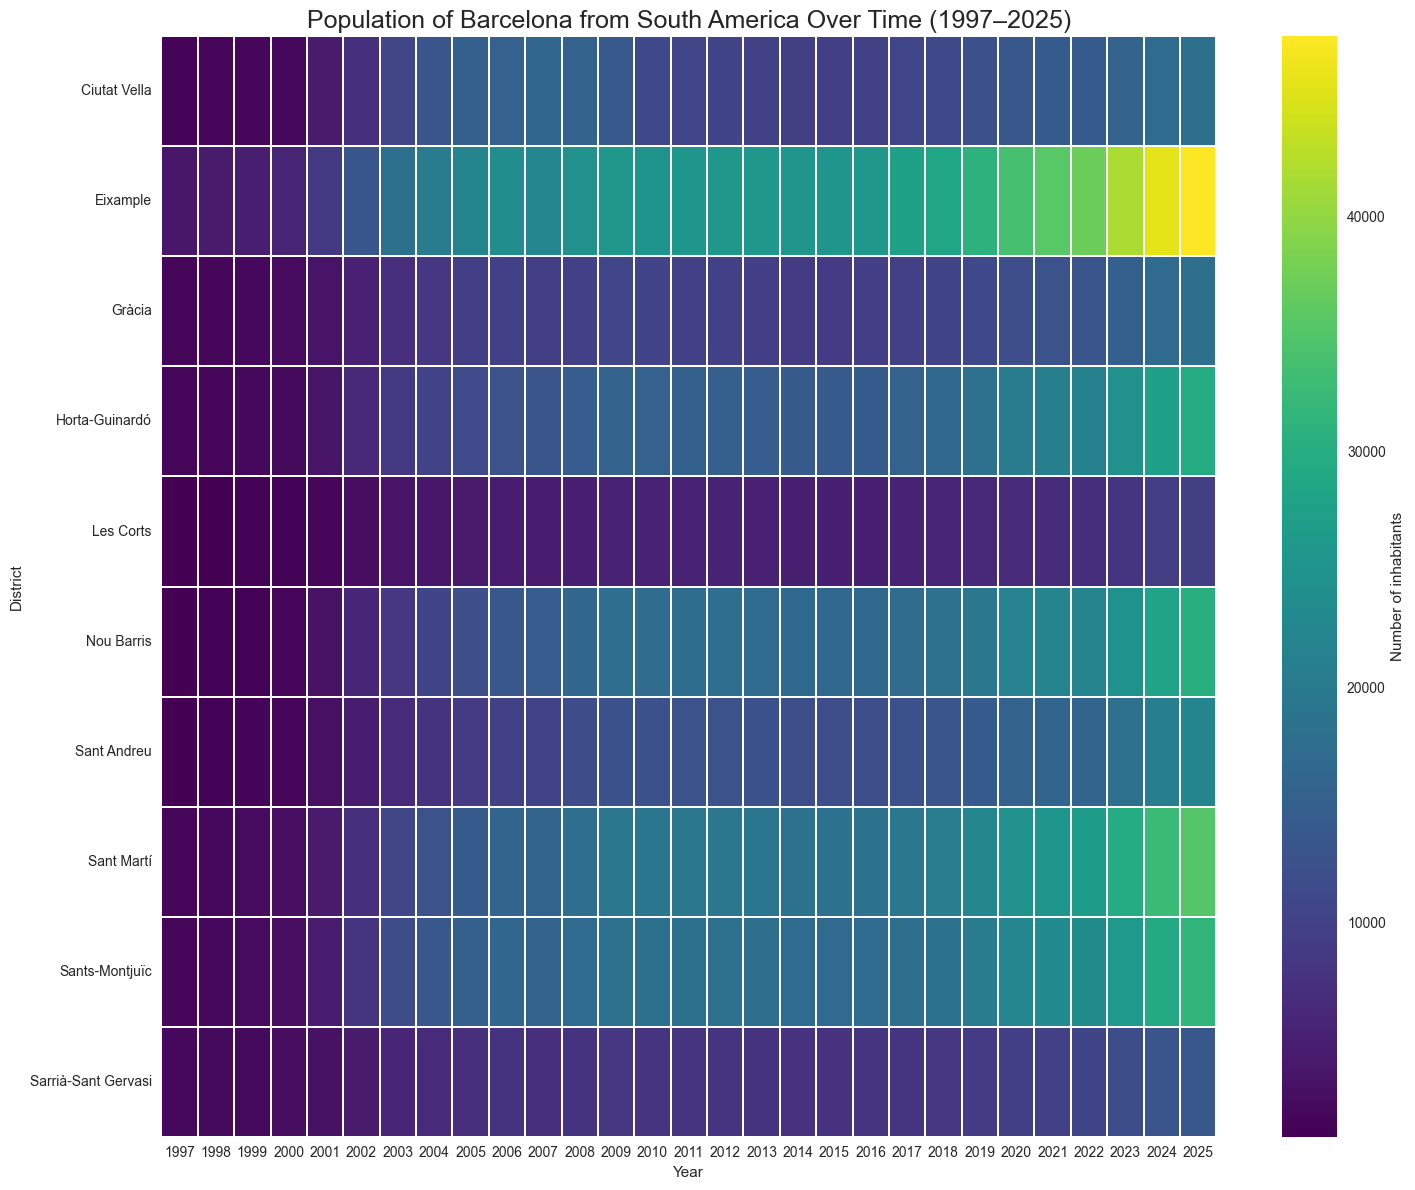

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Aggregate by neighborhood and year
data_path =  '../data/merged_data/merged_birthPlaceRegion_sex.csv'
data_region = pd.read_csv(data_path)
# Get only data from South America for clarity
data_region = data_region[data_region['Birth_Place_Region'] == 'South America']
df_heat = data_region.groupby(['Year_Reference', 'District'], as_index=False)['Value'].sum()

# Pivot for heatmap
df_pivot = df_heat.pivot(index='District', columns='Year_Reference', values='Value')

plt.figure(figsize=(15, 12))
sns.heatmap(
    df_pivot,
    cmap='viridis',
    linewidths=0.1,
    linecolor='white',
    cbar_kws={'label': 'Number of inhabitants'}
)

plt.title('Population of Barcelona from South America Over Time (1997–2025)', fontsize=18)
plt.xlabel('Year')
plt.ylabel('District')
plt.tight_layout()
plt.show()


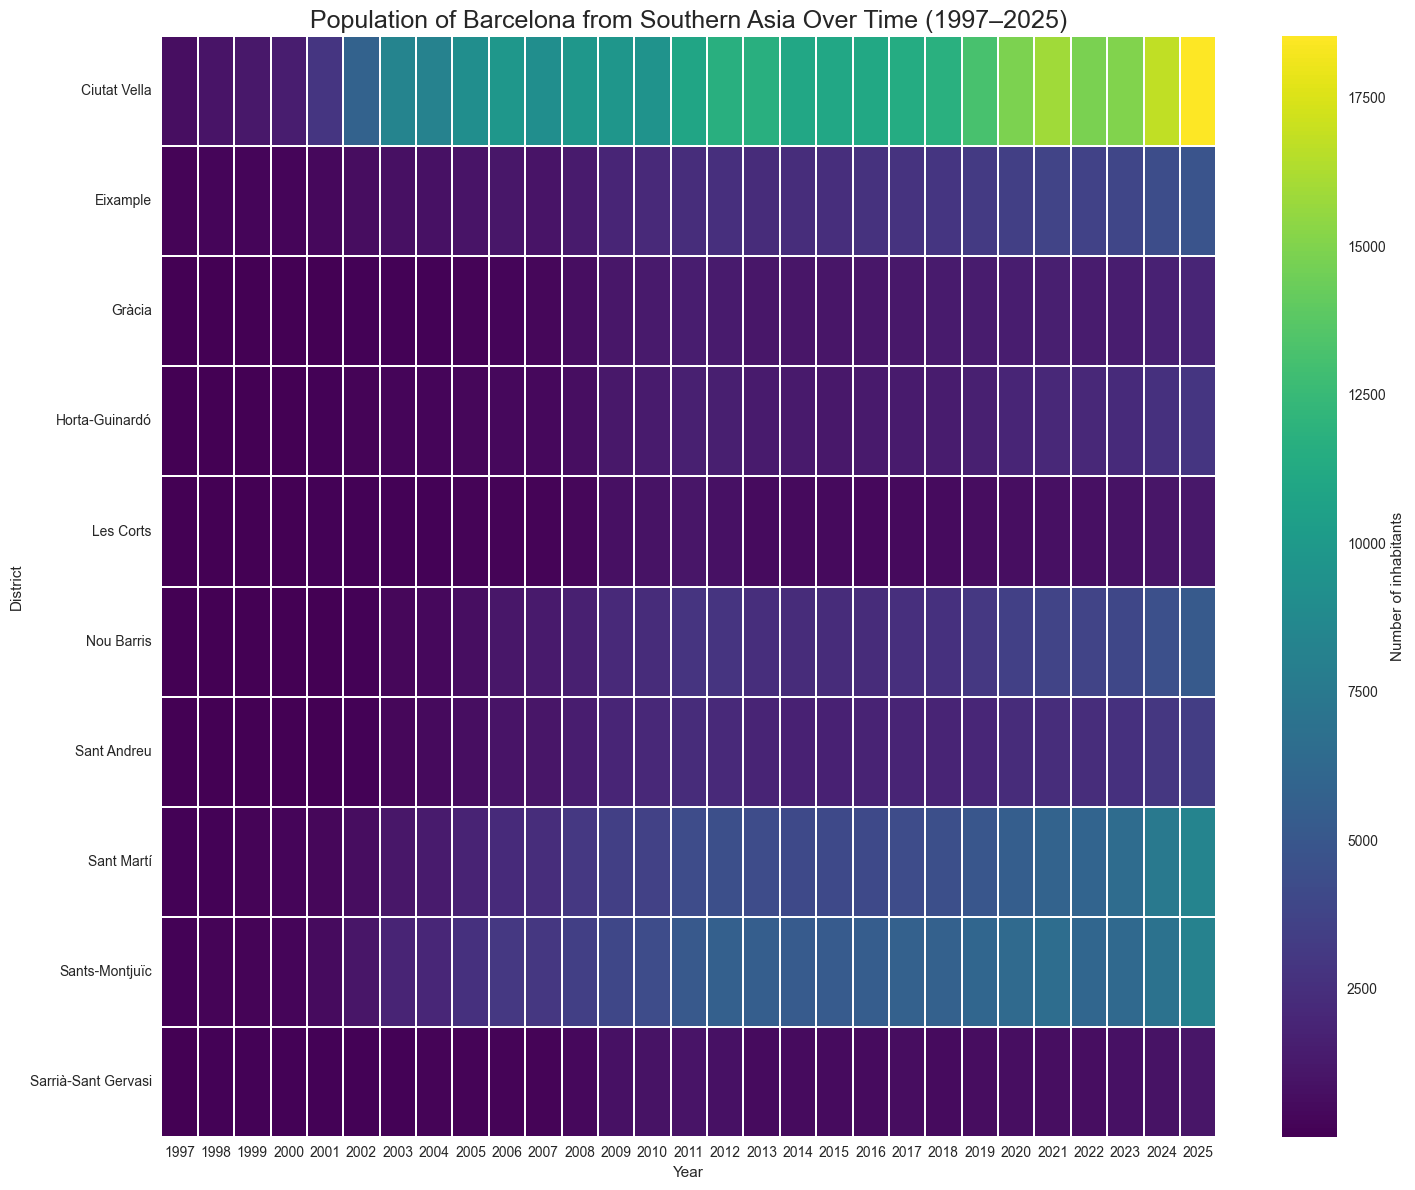

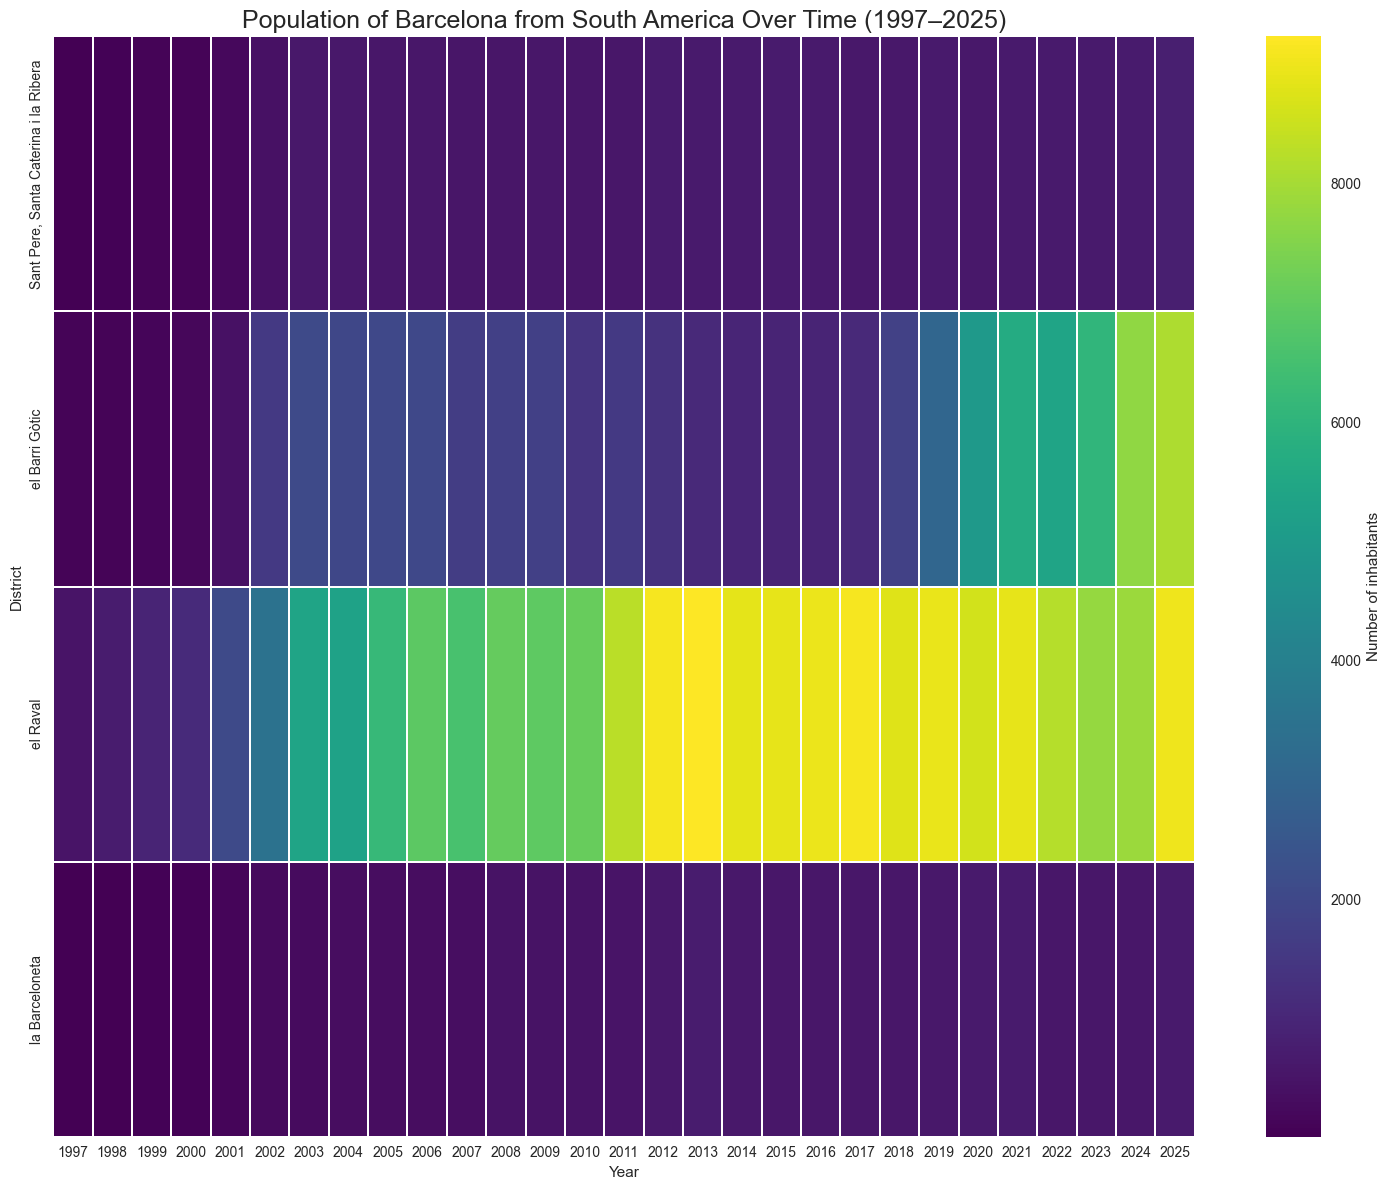

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Aggregate by neighborhood and year
data_path =  '../data/merged_data/merged_birthPlaceRegion_sex.csv'
data_region = pd.read_csv(data_path)
# Get only data from Southern Asia for clarity
data_region = data_region[data_region['Birth_Place_Region'] == 'Southern Asia']
df_heat = data_region.groupby(['Year_Reference', 'District'], as_index=False)['Value'].sum()

# Pivot for heatmap
df_pivot = df_heat.pivot(index='District', columns='Year_Reference', values='Value')

plt.figure(figsize=(15, 12))
sns.heatmap(
    df_pivot,
    cmap='viridis',
    linewidths=0.1,
    linecolor='white',
    cbar_kws={'label': 'Number of inhabitants'}
)

plt.title('Population of Barcelona from Southern Asia Over Time (1997–2025)', fontsize=18)
plt.xlabel('Year')
plt.ylabel('District')
plt.tight_layout()
plt.show()

# Plot only Ciutat Vella district over time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Load data
dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'     
data_region = pd.read_csv(dataPath_region)
# Filter for Ciutat Vella district
data_ciutat_vella = data_region[data_region['District'] == 'Ciutat Vella']
# Filter for Southern Asia
data_southern_asia = data_ciutat_vella[data_ciutat_vella['Birth_Place_Region'] == 'Southern Asia']
df_heat = data_southern_asia.groupby(['Year_Reference', 'Neighborhood'], as_index=False)['Value'].sum()
# Pivot for heatmap
df_pivot = df_heat.pivot(index='Neighborhood', columns='Year_Reference', values='Value')

plt.figure(figsize=(15, 12))
sns.heatmap(
    df_pivot,
    cmap='viridis',
    linewidths=0.1,
    linecolor='white',
    cbar_kws={'label': 'Number of inhabitants'}
)

plt.title('Population of Barcelona from South Asia Over Time (1997–2025)', fontsize=18)
plt.xlabel('Year')
plt.ylabel('District')
plt.tight_layout()
plt.show()

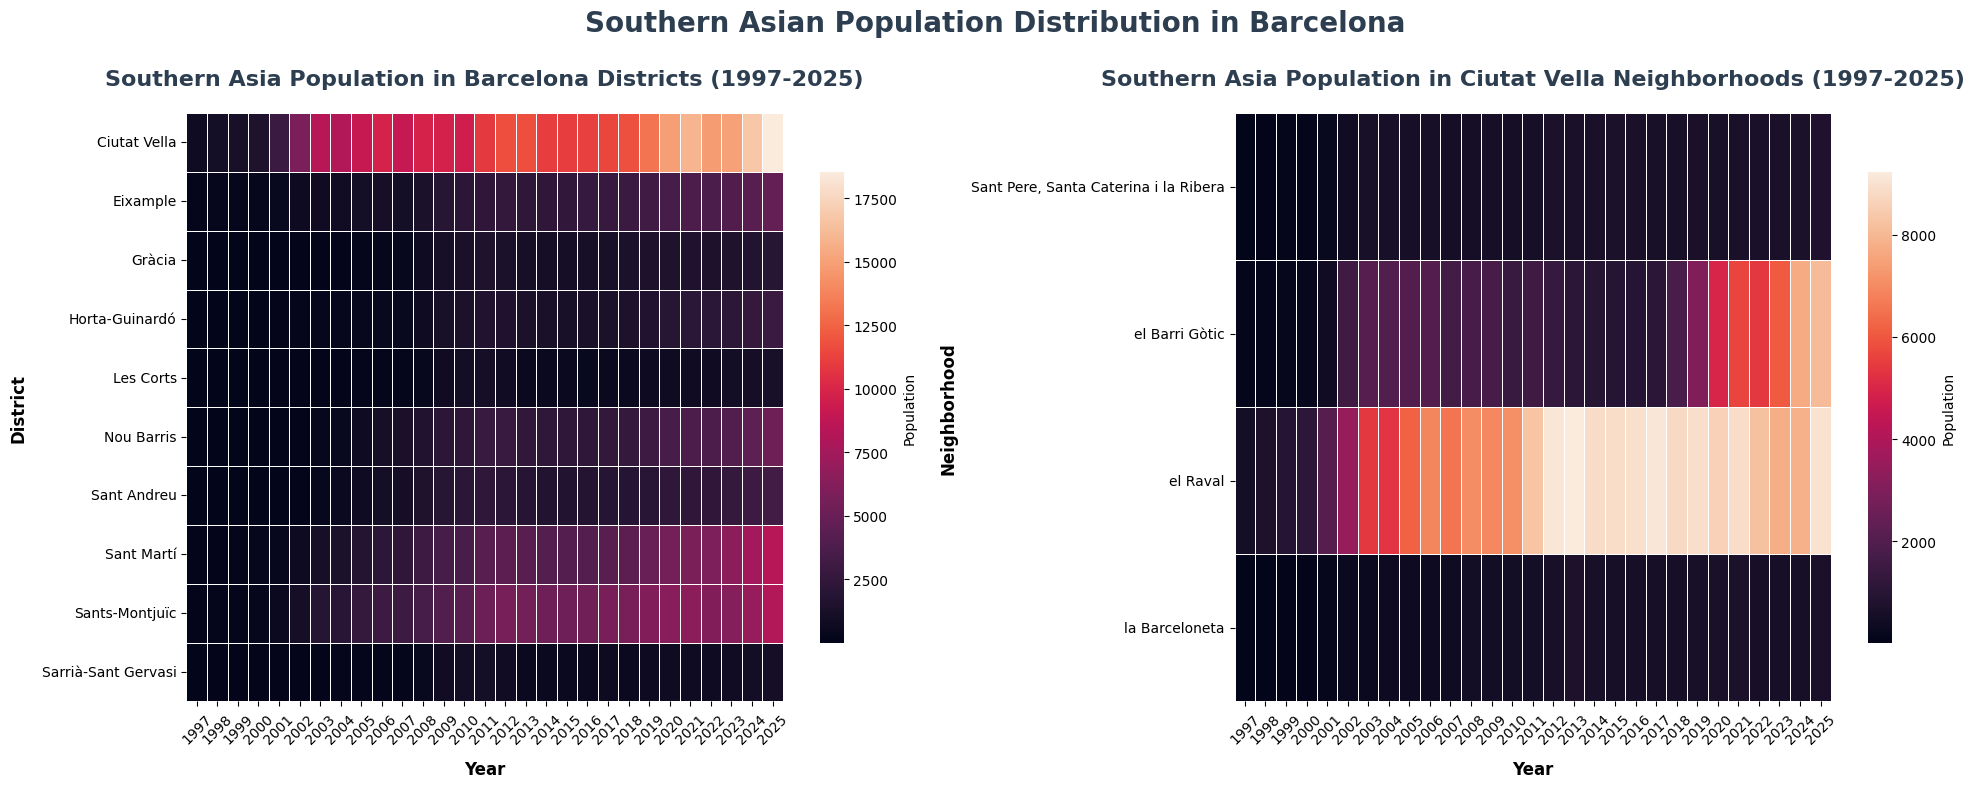

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set up professional style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

# Create figure with light background
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.patch.set_facecolor('white')

# Use colorblind-friendly colormap
cmap = 'rocket'  # or 'mako', 'flare' - better for colorblindness than viridis

# Left subplot - Districts
heat1 = sns.heatmap(
    df_pivot,
    cmap=cmap,
    linewidths=0.5,
    linecolor='white',
    ax=ax1,
    annot=False,  # Add values on cells
    fmt='.0f',   # Format as integers
    annot_kws={'size': 9, 'color': 'white', 'weight': 'bold'},
    cbar_kws={'label': 'Population', 'shrink': 0.8}
)

ax1.set_title('Southern Asia Population in Barcelona Districts (1997-2025)', 
              fontsize=16, fontweight='bold', pad=20, color='#2C3E50')
ax1.set_xlabel('Year', fontsize=12, fontweight='semibold', labelpad=10)
ax1.set_ylabel('District', fontsize=12, fontweight='semibold', labelpad=10)
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis='y', rotation=0)

# Right subplot - Neighborhoods in Ciutat Vella
heat2 = sns.heatmap(
    df_pivot2,
    cmap=cmap,
    linewidths=0.5,
    linecolor='white',
    ax=ax2,
    annot=False,
    fmt='.0f',
    annot_kws={'size': 9, 'color': 'white', 'weight': 'bold'},
    cbar_kws={'label': 'Population', 'shrink': 0.8}
)

ax2.set_title('Southern Asia Population in Ciutat Vella Neighborhoods (1997-2025)', 
              fontsize=16, fontweight='bold', pad=20, color='#2C3E50')
ax2.set_xlabel('Year', fontsize=12, fontweight='semibold', labelpad=10)
ax2.set_ylabel('Neighborhood', fontsize=12, fontweight='semibold', labelpad=10)
ax2.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='y', rotation=0)

# Main title
plt.suptitle('Southern Asian Population Distribution in Barcelona', 
             fontsize=20, fontweight='bold', y=0.98, color='#2C3E50')

plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Save figure
plt.savefig('../data/outputs/southern_asia_population_heatmap.png', 
            dpi=300, bbox_inches='tight', facecolor='white', 
            transparent=False, edgecolor='none')
plt.show()

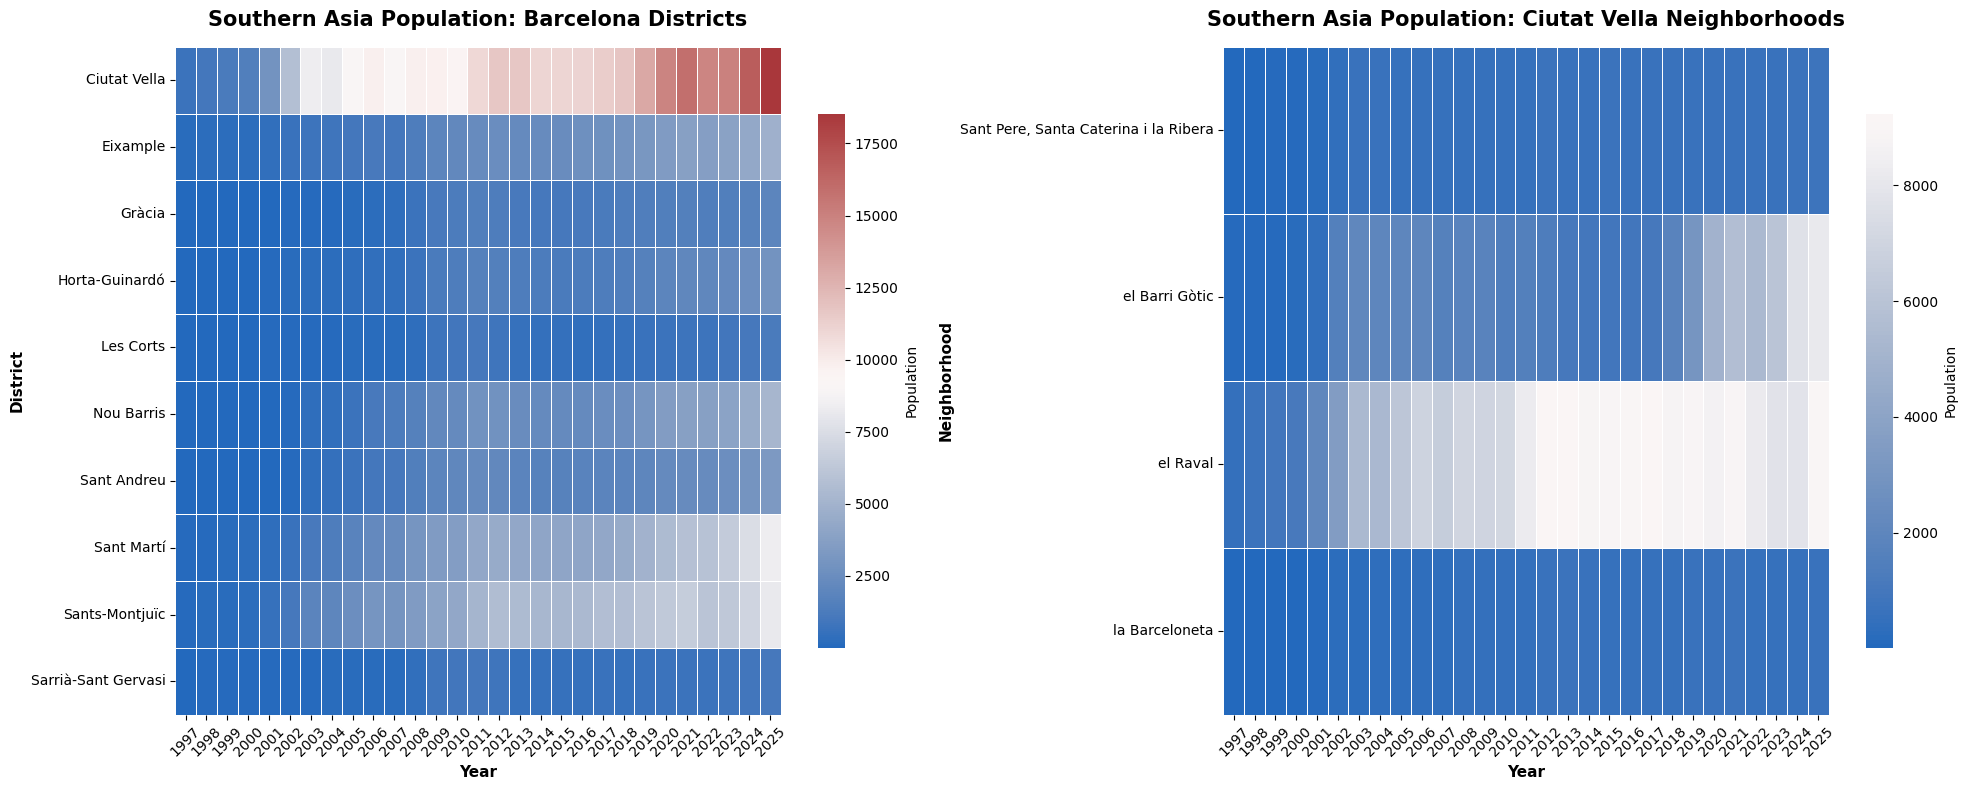

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Calculate common scale for better comparison
vmin = min(df_pivot.min().min(), df_pivot2.min().min())
vmax = max(df_pivot.max().max(), df_pivot2.max().max())

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
fig.patch.set_facecolor('white')

# Use diverging colormap for better perception
cmap = 'vlag'  # Good for showing variations from a center

# Left subplot - Districts
heat1 = sns.heatmap(
    df_pivot,
    cmap=cmap,
    linewidths=0.5,
    linecolor='white',
    ax=ax1,
    annot=False,
    fmt='.0f',
    annot_kws={'size': 8, 'color': 'black', 'weight': 'bold'},
    cbar_kws={'label': 'Population', 'shrink': 0.8},
    center=(vmax + vmin) / 2  # Center the colormap
)

ax1.set_title('Southern Asia Population: Barcelona Districts', 
              fontsize=15, fontweight='bold', pad=15)
ax1.set_xlabel('Year', fontsize=11, fontweight='semibold')
ax1.set_ylabel('District', fontsize=11, fontweight='semibold')
ax1.tick_params(axis='x', rotation=45)

# Right subplot - Neighborhoods
heat2 = sns.heatmap(
    df_pivot2,
    cmap=cmap,
    linewidths=0.5,
    linecolor='white',
    ax=ax2,
    annot=False,
    fmt='.0f',
    annot_kws={'size': 8, 'color': 'black', 'weight': 'bold'},
    cbar_kws={'label': 'Population', 'shrink': 0.8},
    center=(vmax + vmin) / 2
)

ax2.set_title('Southern Asia Population: Ciutat Vella Neighborhoods', 
              fontsize=15, fontweight='bold', pad=15)
ax2.set_xlabel('Year', fontsize=11, fontweight='semibold')
ax2.set_ylabel('Neighborhood', fontsize=11, fontweight='semibold')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Save figure
plt.savefig('../data/outputs/southern_asia_population_heatmap_diverging.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

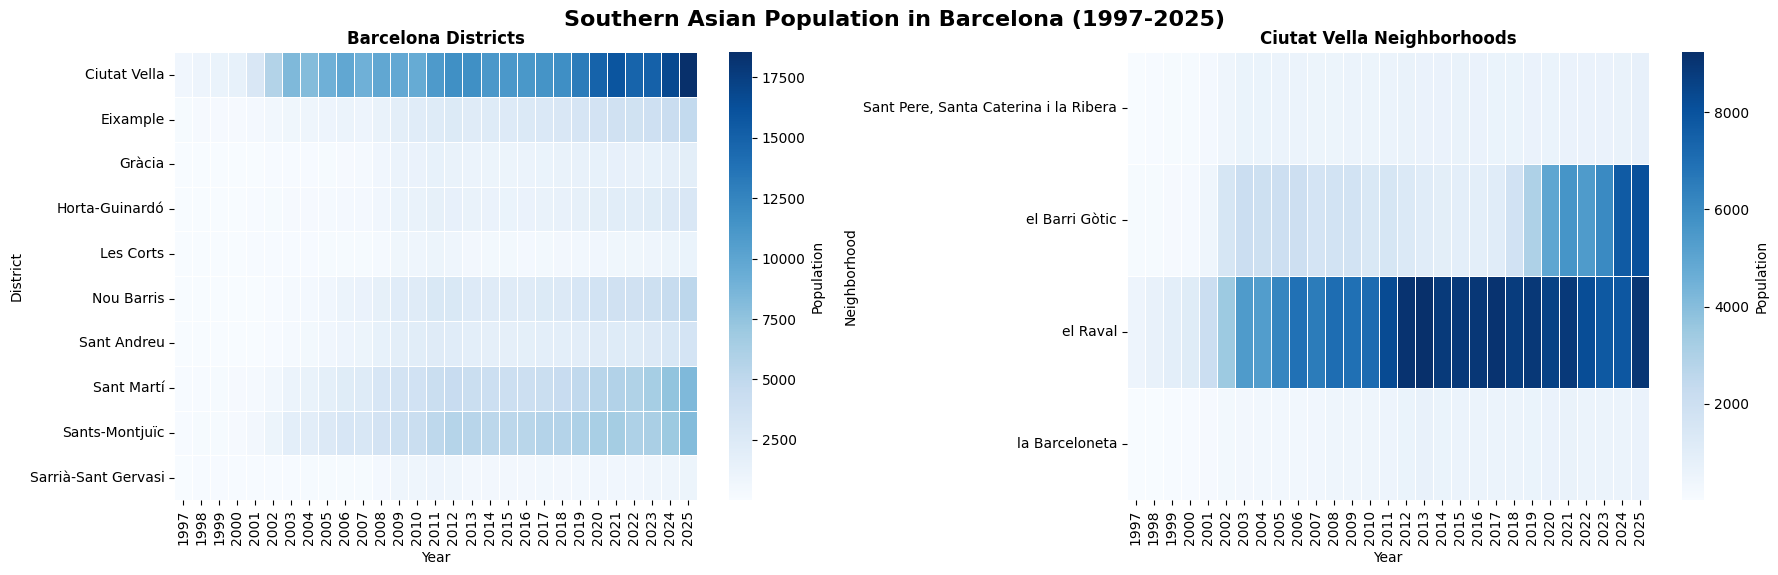

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

# Minimalist style
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Simple, clean heatmaps
sns.heatmap(df_pivot, cmap='Blues', ax=ax1, 
            cbar_kws={'label': 'Population'}, 
            linewidths=0.5, linecolor='white')
ax1.set_title('Barcelona Districts', fontweight='bold')
ax1.set_xlabel('Year')
ax1.set_ylabel('District')

sns.heatmap(df_pivot2, cmap='Blues', ax=ax2,
            cbar_kws={'label': 'Population'}, 
            linewidths=0.5, linecolor='white')
ax2.set_title('Ciutat Vella Neighborhoods', fontweight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('Neighborhood')

plt.suptitle('Southern Asian Population in Barcelona (1997-2025)', 
             fontsize=16, fontweight='bold', y=0.95)

plt.tight_layout()
plt.savefig('../data/outputs/southern_asia_population_heatmap_clean.png', 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()